In [1]:
import os
import re
import sys
import yaml
import multiprocessing
import itertools
import logging

import pypsa

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import matplotlib.colors as mcolors
from matplotlib.legend_handler import HandlerTuple

import cartopy.io.shapereader as shpreader
import pycountry
import cartopy.crs as ccrs

from scipy.spatial import ConvexHull

sns.set_theme(style="whitegrid")

# Replace __file__ with the absolute path of the notebook file
notebook_path = "/home/koen/research/eu-hydrogen/notebooks/scratch.ipynb"

# Insert ../scripts/ to sys.path
sys.path.insert(
    0, os.path.abspath(os.path.join(os.path.dirname(notebook_path), "..", "scripts"))
)

In [2]:
# Set font type: other we get type3 fonts which are problematic for ipe
mpl.rcParams["pdf.fonttype"] = 42

# Ignore INFO:fontTools logging messages
logging.getLogger("fontTools").setLevel(logging.WARNING)

In [3]:
config_fn = "../config/eu-hydrogen.yaml"
config = yaml.safe_load(open(config_fn))

config_default = yaml.safe_load(open("../config/config.default.yaml"))

results_dir = "../results" + (
    "/" + config["run"]["prefix"] if "prefix" in config["run"] else ""
)

scenarios_fn = config["run"]["scenarios"]["file"]
scenarios = yaml.safe_load(open(os.path.join("..", scenarios_fn)))

use_cache = True

In [4]:
green = "#5fc983"
dark_green = "#4b7559"
max_c = "#c95f7e"
min_c = "#975fc9"

titlesize = 9
textsize = 8
labelsize = 7

# cm in inch
cm = 1 / 2.54

page_width = 17.4 * cm

H2_MAX = 110

targets = [(2040, 25)]

In [5]:
def lighten_color(hex_color, amount=0.5):
    # Convert hex color to RGB
    rgb_color = mcolors.hex2color(hex_color)
    # Define white color in RGB
    white = (1, 1, 1)
    # Blend the colors
    blended_color = tuple(
        max((1 - amount) * x + amount * y, 0) for x, y in zip(rgb_color, white)
    )
    # Convert RGB to hex
    return mcolors.to_hex(blended_color)

In [6]:
stat_names = [
    "h2prod",
    "imports",
    "system_cost",
    "obj_bound_dual",
    "h2price",
    "h2value",
    "co2seq",
    "dac",
    "captured_co2",
    "elec_cap",
    "elec_cf",
    "total_onwind",
    "total_offwind",
    "total_solar",
    "total_nuclear",
    "total_h2_storage",
    "smr",
    "smr_cc",
    "ammonia_cracking",
    "bio_hydrogen",
    "fossil_gas",
    "fossil_oil",
    "demand:H2 for industry",
    "demand:land transport fuel cell",
    "demand:Fischer-Tropsch",
    "demand:H2 Fuel Cell",
    "demand:Haber-Bosch",
    "demand:Sabatier",
    "demand:hydrogen for highT industry",
    "demand:hydrogen for mediumT industry",
    "demand:methanolisation",
]


def stats(n: pypsa.Network):
    # H2
    i = n.links.loc[n.links.carrier.isin(["H2 Electrolysis"])].index
    MWh_h2 = -(
        n.links_t.p1.loc[:, i].sum(axis=1) * n.snapshot_weightings.generators
    ).sum()
    h2prod = (MWh_h2 / 33.33) / 1e6

    # Imports
    i = n.generators.loc[n.generators.index.str.contains("green import")].index
    imports = (
        n.generators_t.p.loc[:, i].sum(axis=1) * n.snapshot_weightings.generators
    ).sum() / 1e6

    # System cost
    system_cost = n.statistics.capex().sum() + n.statistics.opex().sum()

    # System cost bound dual
    obj_bound_dual = (
        n.global_constraints.at["total_system_cost", "mu"]
        if "total_system_cost" in n.global_constraints.index
        else np.nan
    )

    # H2 price
    h2_buses = n.buses.index[n.buses.carrier == "H2"]
    h2price = (
        n.buses_t.marginal_price[h2_buses].mean(axis=1)
        * n.snapshot_weightings.generators
    ).sum() / 8760

    # Total value of H2 produced
    elec_i = n.links.index[n.links.carrier == "H2 Electrolysis"]
    h2value = -(
        n.snapshot_weightings.generators
        @ (
            n.links_t.p1[elec_i].rename(n.links.bus1, axis=1)
            * n.buses_t.marginal_price[n.links.bus1[elec_i]]
        )
    ).sum()

    # Total CO2 sequestration
    co2seq = n.stores.loc[n.stores.carrier == "co2 sequestered", "e_nom_opt"].sum()

    # Total amount of CO2 captured by DAC
    dac_i = n.links.loc[n.links.carrier == "DAC"].index
    dac = (
        n.links_t.p0.loc[:, dac_i].sum(axis=1) * n.snapshot_weightings.generators
    ).sum()

    # Total amount of CO2 captured, including industry, BECCS, etc.
    total = 0
    for i in [1, 2, 3, 4]:
        links_i = n.links.loc[n.links.__getattr__(f"bus{i}") == "co2 stored"].index
        co2 = n.links_t.__getattr__(f"p{i}").loc[:, links_i]
        co2 = co2.clip(upper=0)
        total -= (co2.sum(axis=1) * n.snapshot_weightings.generators).sum()

    captured_co2 = total / 1e6

    # Total installed capacity of electrolysers
    elec_cap = n.links.loc[elec_i, "p_nom_opt"].sum()

    # Mean capacity factor of electrolysers
    if elec_cap > 0:
        elec_cf = (
            n.links_t.p0.loc[:, elec_i].sum(axis=1) * n.snapshot_weightings.generators
        ).sum() / (elec_cap * n.snapshot_weightings.generators.sum())
    else:
        elec_cf = np.nan

    # Total installed onshore wind
    total_onwind = n.generators.loc[n.generators.carrier == "onwind", "p_nom_opt"].sum()

    # Total installed offshore wind
    total_offwind = n.generators.loc[
        n.generators.carrier.isin(["offwind-ac", "offwind-dc", "offwind-float"]),
        "p_nom_opt",
    ].sum()

    # Total installed solar
    total_solar = n.generators.loc[n.generators.carrier == "solar", "p_nom_opt"].sum()

    # Total installed nuclear
    nuclear_i = n.links.index[n.links.carrier == "nuclear"]
    total_nuclear = (
        n.links.loc[nuclear_i, "p_nom_opt"] * n.links.loc[nuclear_i, "efficiency"]
    ).sum()

    # Total installed H2 storage
    total_h2_storage = n.stores.loc[n.stores.carrier == "H2 Store", "e_nom_opt"].sum()

    # Total amount of grey H2 produced (SMR links)
    smr_i = n.links.index[n.links.carrier == "SMR"]
    smr_prod_MWh = -(
        n.links_t.p1.loc[:, smr_i].sum(axis=1) * n.snapshot_weightings.generators
    ).sum()
    smr_prod = (smr_prod_MWh / 33.33) / 1e6

    # Total amount of blue H2 produced (SMR CC links)
    smr_cc_i = n.links.index[n.links.carrier == "SMR CC"]
    smr_cc_prod_MWh = -(
        n.links_t.p1.loc[:, smr_cc_i].sum(axis=1) * n.snapshot_weightings.generators
    ).sum()
    smr_cc_prod = (smr_cc_prod_MWh / 33.33) / 1e6

    # Total amount of ammonia cracking (carrier: ammonia cracking)
    ammonia_cracking_i = n.links.index[n.links.carrier == "ammonia cracking"]
    ammonia_cracking_prod_MWh = -(
        n.links_t.p1.loc[:, ammonia_cracking_i].sum(axis=1)
        * n.snapshot_weightings.generators
    ).sum()
    ammonia_cracking_prod = (ammonia_cracking_prod_MWh / 33.33) / 1e6

    # Total amount of bio hydrogen produced (carrier: "solid biomass to hydrogen")
    bio_hydrogen_i = n.links.index[n.links.carrier == "solid biomass to hydrogen"]
    bio_hydrogen_prod_MWh = -(
        n.links_t.p1.loc[:, bio_hydrogen_i].sum(axis=1)
        * n.snapshot_weightings.generators
    ).sum()
    bio_hydrogen_prod = (bio_hydrogen_prod_MWh / 33.33) / 1e6

    oil_i = n.generators.loc[n.generators.carrier == "oil primary"].index
    fossil_oil = (n.snapshot_weightings.generators @ n.generators_t.p[oil_i]).sum()

    gas_i = n.generators.loc[n.generators.carrier == "gas"].index
    fossil_gas = (n.snapshot_weightings.generators @ n.generators_t.p[gas_i]).sum()

    # H2 demand
    h2_balance = (
        n.statistics.energy_balance(nice_names=False)
        .loc[:, :, "H2"]
        .droplevel(0, axis=0)
    )
    h2_demand = -h2_balance.loc[h2_balance < -1e5]
    h2_demand.index = "demand:" + h2_demand.index.astype(str)

    stats = {
        "h2prod": h2prod,
        "imports": imports,
        "system_cost": system_cost,
        "obj_bound_dual": obj_bound_dual,
        "h2price": h2price,
        "h2value": h2value,
        "co2seq": co2seq,
        "dac": dac,
        "captured_co2": captured_co2,
        "elec_cap": elec_cap,
        "elec_cf": elec_cf,
        "smr": smr_prod,
        "smr_cc": smr_cc_prod,
        "ammonia_cracking": ammonia_cracking_prod,
        "bio_hydrogen": bio_hydrogen_prod,
        "fossil_gas": fossil_gas,
        "fossil_oil": fossil_oil,
        "total_onwind": total_onwind,
        "total_offwind": total_offwind,
        "total_solar": total_solar,
        "total_nuclear": total_nuclear,
        "total_h2_storage": total_h2_storage,
    } | {name: h2_demand[name] for name in h2_demand.index}

    for name in stat_names:
        if name not in stats:
            stats[name] = 0

    return stats

In [ ]:
if not use_cache:
    nets = {}

    # Get the overall scenario names as the top level keys in scenarios dict
    if config["run"]["name"] == "all":
        scenario_list = list(scenarios.keys())
    else:
        scenario_list = [config["run"]["name"]]

    # Assume that the following are uniquely defined for each run:
    ll = config["scenario"]["ll"][0]
    clusters = config["scenario"]["clusters"][0]
    opts = config["scenario"]["opts"][0]

    # The following are taken to vary for each run.
    sector_opts = config["scenario"]["sector_opts"]
    planning_horizons = config["scenario"]["planning_horizons"]
    slacks = config["scenario"]["slack"]
    senses = ["min", "max"]

    resolution = None

    # If resolution not none, replace all instances of "\d+seg" with resolution in sector_opts
    if resolution is not None:
        sector_opts = [
            re.sub(r"\d+seg", resolution, s) if "seg" in s else s + "-" + resolution
            for s in sector_opts
        ]

    def load_stats(file):
        return (
            stats(pypsa.Network(file))
            if os.path.exists(file)
            else {v: np.nan for v in stat_names}
        )

    index = list(
        itertools.product(scenario_list, sector_opts, planning_horizons, slacks, senses)
    )
    index_opt = list(
        itertools.product(scenario_list, sector_opts, planning_horizons, [0], ["opt"])
    )

    with multiprocessing.Pool(30) as pool:
        networks = pool.map(
            load_stats,
            [
                f"{results_dir}/{s}/postnetworks/base_s_{clusters}_l{ll}_{opts}_{o}_{h}_{sense}{slack}.nc"
                for s, o, h, slack, sense in index
            ],
        )

        networks.extend(
            pool.map(
                load_stats,
                [
                    f"{results_dir}/{s}/postnetworks/base_s_{clusters}_l{ll}_{opts}_{o}_{h}.nc"
                    for s, o, h, _, _ in index_opt
                ],
            )
        )

    networks = dict(zip(index + index_opt, networks))

In [8]:
if not use_cache:
    pd.DataFrame(networks).T.reset_index()

In [9]:
if not use_cache:
    df = pd.DataFrame(networks).T.reset_index()
    df.rename(
        columns={
            "level_0": "scenario",
            "level_1": "opts",
            "level_2": "horizon",
            "level_3": "slack",
            "level_4": "sense",
        },
        inplace=True,
    )

    # Split the "scenario" column into "year" and "biomass"; has format "Y<year>_B<biomass_flag>"
    df[["year", "B"]] = df["scenario"].str.extract(r"Y(\d+)_B([a-z])")

    # Drop the "scenario" column
    df.drop(columns=["scenario"], inplace=True)

    # Strip any suffix of the form "-\d+seg" from the "opts" column
    df["opts"] = df["opts"].str.replace(r"-\d+seg", "", regex=True)

    # The "opts" column has the form "XX-YY-ZZ-..."; we want to split this into separate columns and keep only the last character
    flags = list(map(lambda s: s[0], df.at[0, "opts"].split("-")))
    df[flags] = df["opts"].str.split("-", expand=True).map(lambda s: s[-1])
    df.drop(columns=["opts"], inplace=True)

    # Add a column concatenating the year and flags
    df["scenario"] = (
        df["year"] + df["B"] + df[flags].apply(lambda x: "".join(x), axis=1)
    )

    # Now set the index to the scenario, year, flags, slack and horizon
    df.set_index(
        ["scenario", "year", "B"] + flags + ["sense", "slack", "horizon"], inplace=True
    )

    df.to_csv(f"cache_{results_dir.split('/')[-1]}.csv")

    display(df)
else:
    fn = f"cache_{results_dir.split('/')[-1]}.csv"
    cols = pd.read_csv(fn).columns
    df = pd.read_csv(fn, index_col=list(range(len(cols) - len(stat_names))))

    # Convert "year" index level values from int to str
    df.index = df.index.set_levels(df.index.levels[1].astype(str), level=1)

    display(df)

h2prod       imports  \
scenario  year B C I E T sense slack horizon                               
1987aaaaa 1987 a a a a a min   0.02  2025    -0.000000e+00  3.991996e-11   
                         max   0.02  2025     3.777044e+00  2.180543e-07   
                         min   0.05  2025    -0.000000e+00  4.963475e-11   
                         max   0.05  2025     8.529014e+00  8.120431e-08   
                         min   0.10  2025    -0.000000e+00  4.304705e-11   
...                                                    ...           ...   
2020ccbbc 2020 c c b b c opt   0.00  2030     1.288859e-08  1.132986e-06   
                                     2035     3.791459e-08  3.280720e-06   
                                     2040     3.113074e-02  1.055823e+02   
                                     2045     2.824175e-02  1.720704e+02   
                                     2050     8.448284e-02  2.726778e+02   

                                               system_cost  obj_bound_dual  \
scenario  year B C I E T sense slack horizon                                 
1987aaaaa 1987 a a a a a min   0.02  2025     9.798039e+11             NaN   
                         max   0.02  2025     9.920008e+11      -12.530765   
                         min   0.05  2025     9.804858e+11             NaN   
                         max   0.05  2025     1.013991e+12      -12.143044   
                         min   0.10  2025     9.822385e+11             NaN   
...                                                    ...             ...   
2020ccbbc 2020 c c b b c opt   0.00  2030     8.044610e+11             NaN   
                                     2035     7.154815e+11             NaN   
                                     2040     6.719982e+11             NaN   
                                     2045     6.253177e+11             NaN   
                                     2050     6.100248e+11             NaN   

                                                h2price       h2value  \
scenario  year B C I E T sense slack horizon                            
1987aaaaa 1987 a a a a a min   0.02  2025     59.912696 -0.000000e+00   
                         max   0.02  2025      0.525779  6.464627e+07   
                         min   0.05  2025     59.905327 -0.000000e+00   
                         max   0.05  2025      0.479500  1.344606e+08   
                         min   0.10  2025     59.910073 -0.000000e+00   
...                                                 ...           ...   
2020ccbbc 2020 c c b b c opt   0.00  2030     60.806301  2.757203e+01   
                                     2035     62.409547  8.332885e+01   
                                     2040     71.888398  7.148952e+07   
                                     2045     62.437452  5.730498e+07   
                                     2050     62.595875  1.705365e+08   

                                                    co2seq        dac  \
scenario  year B C I E T sense slack horizon                            
1987aaaaa 1987 a a a a a min   0.02  2025     0.000000e+00   0.297493   
                         max   0.02  2025     5.101518e+01   0.072670   
                         min   0.05  2025     0.000000e+00   0.283566   
                         max   0.05  2025     8.309260e+00   0.025925   
                         min   0.10  2025     0.000000e+00   0.276533   
...                                                    ...        ...   
2020ccbbc 2020 c c b b c opt   0.00  2030     9.823465e+06   0.180424   
                                     2035     2.908840e+08   0.476474   
                                     2040     5.000000e+08  20.323158   
                                     2045     5.132864e+08   0.262607   
                                     2050     5.709619e+08   0.413933   

                                              captured_co2      elec_cap  ...  \
scenario  year B C I E T sense slack horizon                       

# Statistics

In [10]:
# Difference between max and min for each scenario, slack and horizon
display(
    (df.xs("max", level="sense") - df.xs("min", level="sense"))
    .groupby(level=["slack", "horizon"])
    .h2prod.mean()
)

# Difference between max and opt for each scenario, slack and horizon
display(
    (df.xs("max", level="sense").xs(0.05, level="slack") - df.xs("opt", level="sense"))
    .groupby(level="horizon")
    .h2prod.mean()
)

slack  horizon
0.02   2025        5.174396
       2030        5.823950
       2035       16.110808
       2040       27.162887
       2045       21.159861
       2050       22.999862
0.05   2025       11.449794
       2030       12.438044
       2035       25.124123
       2040       40.153890
       2045       34.110007
       2050       38.099681
0.10   2025       21.447838
       2030       22.723849
       2035       37.151771
       2040       56.527262
       2045       51.739258
       2050       59.774833
Name: h2prod, dtype: float64

horizon
2025    11.449794
2030    12.413997
2035    19.901611
2040    28.726119
2045    24.624435
2050    29.073426
Name: h2prod, dtype: float64

In [ ]:
# Average system cost per time horizon and sense
print("Min:")
display(
    (df.groupby(["horizon", "sense"]).system_cost.min().unstack() / 1e9)
    .round()
    .loc[[2030, 2040, 2050]]
)
print("Max:")
display(
    (df.groupby(["horizon", "sense"]).system_cost.max().unstack() / 1e9)
    .round()
    .loc[[2030, 2040, 2050]]
)
print("Average:")
display(
    (df.groupby(["horizon", "sense"]).system_cost.mean().unstack() / 1e9)
    .round()
    .loc[[2030, 2040, 2050]]
)

Min:


sense,max,min,opt
horizon,,,
2030,818.0,804.0,804.0
2040,685.0,672.0,672.0
2050,623.0,610.0,610.0


Max:


sense,max,min,opt
horizon,,,
2030,1054.0,977.0,974.0
2040,1396.0,1390.0,1273.0
2050,1203.0,1146.0,1073.0


Average:


sense,max,min,opt
horizon,,,
2030,927.0,885.0,885.0
2040,960.0,933.0,910.0
2050,817.0,783.0,779.0


# Comparison with literature

In [12]:
lit_review = pd.read_csv("lit-review-ranges.csv", index_col=0)

display(lit_review)

,study-name,range-lower,range-upper,seq
0,blanco,0,0,1400
1,blanco,90,120,0
2,pickering,76,157,0
3,seck,38,78,1400
4,neumann,69,80,200
5,zeyen,114,119,200
6,beres,0,43,1000
7,beres,53,76,300
8,schreyer,8,76,270
9,kountouris,30,51,250


In [13]:
C_to_seq = {"a": 275, "b": 550, "c": 1100}

current_ranges = (
    df.xs(2050, level="horizon")
    .groupby(["C", "slack"])
    .agg({"h2prod": ["min", "max"]})
    .copy()
)
current_ranges = current_ranges.reset_index()
current_ranges.C = current_ranges.C.map(C_to_seq)

current_ranges

C slack        h2prod            
                         min         max
0    275  0.00  9.754529e-09   53.794215
1    275  0.02 -0.000000e+00   70.974176
2    275  0.05 -0.000000e+00   93.069748
3    275  0.10 -0.000000e+00  103.112935
4    550  0.00  1.910238e-11   37.442185
5    550  0.02 -0.000000e+00   53.702535
6    550  0.05 -0.000000e+00   64.615343
7    550  0.10 -0.000000e+00   88.886462
8   1100  0.00  6.201681e-09   27.666698
9   1100  0.02 -0.000000e+00   45.587198
10  1100  0.05 -0.000000e+00   64.786415
11  1100  0.10 -0.000000e+00   90.239752

Plotting 1240 of 1512 points


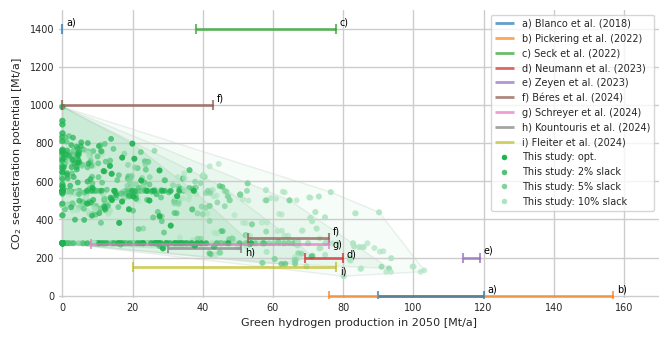

In [14]:
# Plot thick horizontal lines from x="range-lower" to x="range-lower" and y="seq" (using corresponding columns in df)
fig, ax = plt.subplots(figsize=(page_width, 9 * cm), layout="tight")

# Scatter plot of present study results with shading for different slack levels
df_sel = df.xs(2050, level="horizon").copy()
print(f"Plotting {len(df_sel.h2prod.dropna())} of {len(df_sel)} points")
df_sel.co2seq = df_sel.co2seq / 1e6
palette = {
    0.0: lighten_color(green, -0.4),
    0.02: lighten_color(green, -0.1),
    0.05: lighten_color(green, 0.2),
    0.10: lighten_color(green, 0.5),
}
sns.scatterplot(
    data=df_sel,
    x="h2prod",
    y="co2seq",
    hue="slack",
    palette=palette,
    size=1,
    alpha=0.7,
    linewidth=0,
    legend=False,
    ax=ax,
)

# Plot convex hulls for each value in the slack index level
for slack in sorted(df_sel.index.get_level_values("slack").unique()):
    d = df_sel.xs(slack, level="slack")[["h2prod", "co2seq"]].dropna()
    hull = ConvexHull(d)
    ax.fill(
        d.iloc[hull.vertices]["h2prod"],
        d.iloc[hull.vertices]["co2seq"],
        color=palette[slack],
        edgecolor=dark_green,
        alpha=0.1,
        linewidth=1,
        zorder=-1,
    )

study_labels = {
    "blanco": "a) Blanco et al. (2018)",
    "pickering": "b) Pickering et al. (2022)",
    "seck": "c) Seck et al. (2022)",
    "neumann": "d) Neumann et al. (2023)",
    "zeyen": "e) Zeyen et al. (2023)",
    "beres": "f) Béres et al. (2024)",
    "schreyer": "g) Schreyer et al. (2024)",
    "kountouris": "h) Kountouris et al. (2024)",
    "fleiter": "i) Fleiter et al. (2024)",
}

# Colormap by studyname
cmap = plt.get_cmap("tab10")
colors = {name: cmap(i) for i, name in enumerate(lit_review["study-name"].unique())}

annot_y_shift = {
    "pickering": 10,
    "blanco": 10,
    "seck": 10,
    "neumann": -10,
    "zeyen": 10,
    "beres": 10,
    "schreyer": -30,
    "kountouris": -50,
    "fleiter": -50,
}
for i, row in lit_review.iterrows():
    if row["range-lower"] == row["range-upper"]:
        ax.scatter(
            row["range-lower"],
            row["seq"],
            marker="|",
            s=60,
            color=colors[row["study-name"]],
            alpha=0.7,
            label=study_labels[row["study-name"]],
        )
    else:
        ax.plot(
            [row["range-lower"], row["range-upper"]],
            [row["seq"], row["seq"]],
            color=colors[row["study-name"]],
            alpha=0.7,
            linewidth=2,
            solid_capstyle="butt",
            label=study_labels[row["study-name"]],
        )
        ax.scatter(
            [row["range-lower"], row["range-upper"]],
            [row["seq"], row["seq"]],
            color=colors[row["study-name"]],
            alpha=0.7,
            marker="|",
            s=60,
            label=None,
        )
    # Place annotation at the end of the line: first letter of study name
    ax.text(
        row["range-upper"] + 1,
        row["seq"] + annot_y_shift[row["study-name"]],
        study_labels[row["study-name"]][0] + ")",
        fontsize=labelsize,
        verticalalignment="bottom",
        horizontalalignment="left",
        color="black",
    )

# Increase zorder of line with blanco et al. data. Find line by label
for line in ax.lines:
    if line.get_label() == study_labels["blanco"]:
        line.set_zorder(10)

ax.set_xlim(-1, 170)
ax.set_ylim(-10, 1500)

# Grid
# ax.grid(True, which="minor", linestyle="--", linewidth=0.5)
ax.grid(True, which="major", linestyle="-", linewidth=1)

# Splines off
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)

# Legend: add artificial handles for this study slack levels
handles, labels = ax.get_legend_handles_labels()
for slack, color in palette.items():
    handles.append(
        plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color, markersize=5)
    )
    slack_formatted = re.sub("^0% slack", "opt.", f"{slack * 100:.0f}% slack")
    labels.append(f"This study: {slack_formatted}")
# Remove duplicates
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), fontsize=labelsize)

# Axis labels
ax.set_xlabel("Green hydrogen production in 2050 [Mt/a]", fontsize=textsize)
ax.set_ylabel("CO$_2$ sequestration potential [Mt/a]", fontsize=textsize)

# Tick marks off
ax.tick_params(axis="both", which="both", length=0, labelsize=labelsize)

plt.savefig("figures/lit_review_ranges_alt.pdf", transparent=True)
plt.show()

# Plots

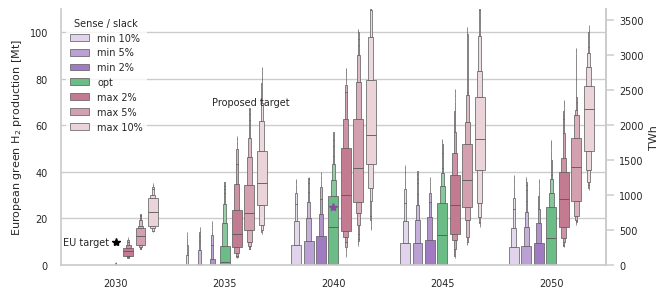

In [15]:
fig, ax = plt.subplots(
    figsize=(page_width, 8 * cm),
    layout="tight",
)

df_sel = df.copy()

# Add new index to df_sel; concatenation of sense and slack index levels
df_sel["hue"] = df_sel.index.get_level_values("sense") + df_sel.index.get_level_values(
    "slack"
).map(lambda x: f"_{x:.2f}")

palette = {"opt_0.00": green}
lighten = {0.0: 0, 0.02: 0.1, 0.05: 0.35, 0.10: 0.7}
for slack in df.index.get_level_values("slack").unique():
    palette[f"min_{slack:.2f}"] = lighten_color(min_c, lighten[slack])
    palette[f"max_{slack:.2f}"] = lighten_color(max_c, lighten[slack])

sns.boxenplot(
    data=df_sel,
    x="horizon",
    y="h2prod",
    hue="hue",
    width_method="exponential",
    k_depth="full",
    hue_order=[
        "min_0.10",
        "min_0.05",
        "min_0.02",
        "opt_0.00",
        "max_0.02",
        "max_0.05",
        "max_0.10",
    ],
    palette=palette,
    orient="v",
    gap=0.2,
    linewidth=0.5,
    native_scale=True,
    ax=ax,
)

# Format legend items nicely; "min_0.05" -> "5% min."; "opt_0.00" -> "Optimum"
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles=handles,
    labels=[
        (
            "opt"
            if "opt" in l
            else f"{l.split('_')[0]} {int(float(l.split('_')[1]) * 100)}%"
        )
        for l in labels
    ],
    fontsize=labelsize,
    title="Sense / slack",
    title_fontsize=labelsize,
    loc="upper left",
    edgecolor="none",
)

ax.set_ylim(0, H2_MAX)
ax.set_xlim(2027.5, 2052.5)

# Turn off x-grid
ax.xaxis.grid(False)

# Turn off spines
ax.spines["top"].set_visible(False)
# ax.spines["right"].set_visible(False)
# ax.spines["left"].set_visible(False)

# Set ticks at every 5 years
ax.xaxis.set_major_locator(plt.MultipleLocator(5))

# Tick size
ax.tick_params(axis="both", which="major", labelsize=labelsize)

# Set labels
ax.set_ylabel("European green H$_2$ production [Mt]", fontsize=textsize)
ax.set_xlabel(None)

# Add black star marker at (2030, 10) to indicate EU target, and annotate
ax.plot(2030, 10, marker="*", color="black", markersize=6, clip_on=False)
ax.text(2029.7, 10, "EU target", va="center", ha="right", size=labelsize)

# Add marker for 2040 target
target_colour = "#864da3"
ax.plot(2040, 25, marker="*", color=target_colour, markersize=6, clip_on=False)
ax.annotate(
    xy=(2040, 25),
    text="Proposed target",
    xytext=(2038, 70),
    va="center",
    ha="right",
    size=labelsize,
)

# Add second y axis with TWh (where 1 Mt H2 = 33.3 TWh)
ax2 = ax.secondary_yaxis("right", functions=(lambda x: x * 33.3, lambda x: x / 33.3))
# Label, tick parameters
ax2.set_ylabel("TWh", fontsize=textsize)
# Set color of tick marks (but not of text) to lightgrey
ax2.tick_params(axis="y", which="major", labelsize=labelsize, color="lightgrey")

fig.savefig("figures/pathways_alt.pdf", dpi=300, transparent=True)

In [16]:
df.xs(2040, level="horizon").groupby(["sense", "slack"]).h2prod.quantile(
    [0.25, 0.75]
).unstack().round(0)

0.25  0.75
sense slack            
max   0.02   15.0  50.0
      0.05   27.0  63.0
      0.10   43.0  79.0
min   0.02    0.0  12.0
      0.05    0.0  10.0
      0.10    0.0   9.0
opt   0.00    0.0  30.0

In [17]:
df.xs(2040, level="horizon").xs(0.05, level="slack").h2prod.unstack("sense").dropna()

,,,,,,sense,min,max
scenario,year,B,C,I,E,T,,
1987aaaaa,1987,a,a,a,a,a,37.083570,69.858212
1987aaaab,1987,a,a,a,a,b,27.026177,54.710808
1987aaaac,1987,a,a,a,a,c,15.293455,42.425299
1987aaaba,1987,a,a,a,b,a,37.713683,99.316973
1987aaabb,1987,a,a,a,b,b,27.839728,78.989778
...,...,...,...,...,...,...,...,...
2020ccbab,2020,c,c,b,a,b,-0.000000,14.336304
2020ccbac,2020,c,c,b,a,c,-0.000000,7.942551
2020ccbba,2020,c,c,b,b,a,-0.000000,47.115995


In [18]:
def intersection_by_quantile(data, q):
    lower = pd.Series(index=data.index.get_level_values("horizon").unique())
    upper = pd.Series(index=data.index.get_level_values("horizon").unique())
    for h in data.index.get_level_values("horizon").unique():
        interval_boundaries = (
            data.xs(h, level="horizon").h2prod.sort_values().dropna().unique()
        )
        if len(interval_boundaries) < 2:
            continue
        density = pd.Series(
            index=pd.IntervalIndex.from_breaks(interval_boundaries, closed="left"),
            dtype=float,
        )
        data_unstacked = data.xs(h, level="horizon").h2prod.unstack("sense").dropna()
        mids = np.array(density.index.mid)
        max_vals = data_unstacked["max"].values
        min_vals = data_unstacked["min"].values
        denom = len(data_unstacked)
        # Use broadcasting to count rows satisfying the condition for each mid
        counts = (
            (max_vals[np.newaxis, :] > mids[:, np.newaxis])
            & (min_vals[np.newaxis, :] < mids[:, np.newaxis])
        ).sum(axis=1)
        density[:] = counts / denom

        if len(density[density >= q]) > 0:
            lower[h] = density.index[density >= q].min().left
            upper[h] = density.index[density >= q].max().right
        else:
            # If no intersection, set lower and upper to mid of interval with maximum density
            lower[h] = density.idxmax().mid
            upper[h] = density.idxmax().mid

    return lower, upper

In [19]:
# Plot bands representing the range between maximum green hydrogen production
# over scenarios in cost (sense) minimisation, and minimum production over
# scenarios in cost maximisation (for each slack level)

robust_colour = "#5dc4ad"
target_colour = "#864da3"


quantile_colors = {
    1: robust_colour,
    0.9: lighten_color(robust_colour, 0.25),
    0.8: lighten_color(robust_colour, 0.5),
    0.7: lighten_color(robust_colour, 0.75),
}


def plot_robust_ranges(data, quantiles, slack, ax, plot_targets=True, max_y=50):
    for q in quantiles:
        lower, upper = intersection_by_quantile(data.xs(slack, level="slack").copy(), q)
        ax.fill_between(
            lower.index,
            lower,
            upper,
            color=quantile_colors[q],
            edgecolor="none",
            label=None,
            zorder=-1,
        )

    # Plot median cost-optimal pathway
    sns.lineplot(
        data=data.xs("opt", level="sense"),
        x="horizon",
        y="h2prod",
        color=dark_green,
        linewidth=2,
        linestyle="--",
        estimator=np.median,
        errorbar=None,
        ax=ax,
    )

    # Add black star marker at (2030, 10) to indicate EU target, and annotate
    ax.plot(
        2030,
        10,
        marker="*",
        color="black",
        markersize=8,
        clip_on=False,
        label="EU target",
        linewidth=0,
    )

    # Add star markers to indicate proposed targets
    if plot_targets:
        ax.plot(
            targets[0][0],
            targets[0][1],
            marker="*",
            color=target_colour,
            markersize=8,
            clip_on=False,
            label="Proposed target",
            linewidth=0,
        )
        if len(targets) > 1:
            ax.plot(
                targets[1][0],
                targets[1][1],
                marker="*",
                color=target_colour,
                markersize=8,
                clip_on=False,
            )

    ax.set_xlim(2030, 2050)
    ax.set_ylim(0, max_y)

    # Turn off x-grid
    ax.xaxis.grid(False)

    # Put y grid in front of the plot (zorder)
    ax.yaxis.grid(True, which="major", linestyle="--", linewidth=1, zorder=10)

    # Turn off spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

    # Set ticks at every 5 years
    ax.xaxis.set_major_locator(plt.MultipleLocator(5))

    # Tick size
    ax.tick_params(axis="both", which="major", labelsize=labelsize)

    # Set labels
    ax.set_xlabel(None)

    # Right-justify the tick label that says "2050" in axs[0]
    for tick in ax.xaxis.get_majorticklabels():
        if tick.get_text() == "2050":
            tick.set_horizontalalignment("right")

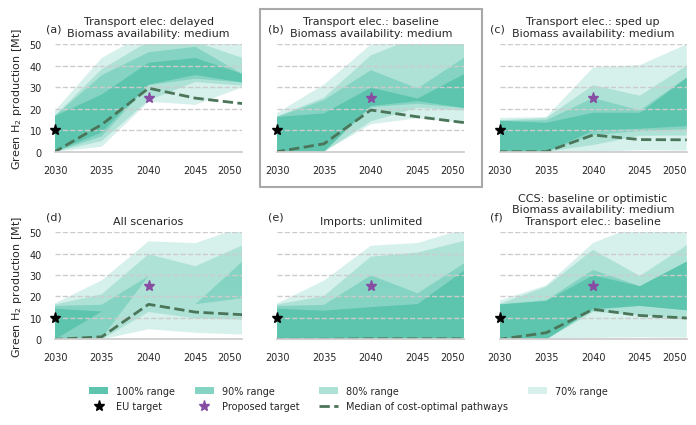

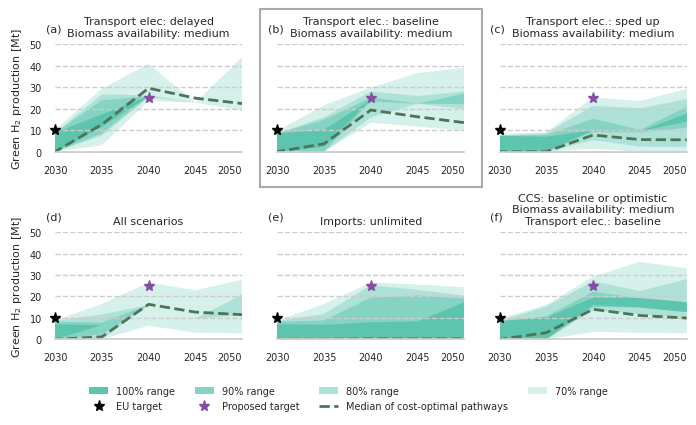

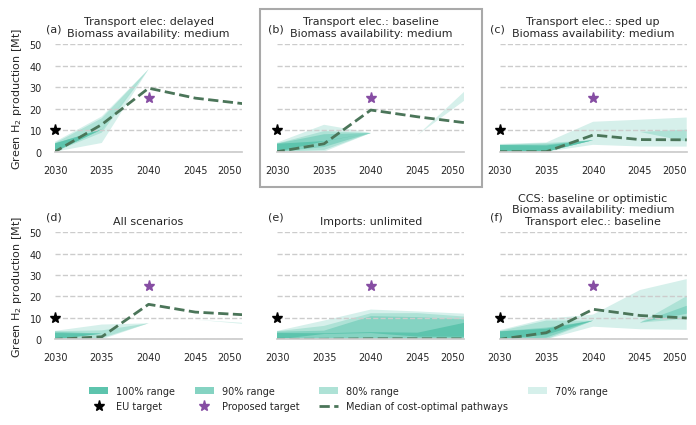

In [20]:
for slack_level in [0.1, 0.05, 0.02]:
    ncols = 3
    fig, axs = plt.subplots(
        2,
        ncols,
        figsize=(page_width, 9 * cm),
        sharey=True,
        layout="constrained",
        gridspec_kw={"hspace": 0.1, "wspace": 0.1},
    )

    quantiles = [0.7, 0.8, 0.9, 1]

    settings = {
        "pessimistic_transportation": {"B": "b", "T": "a"},
        "baseline_transportation": {"B": "b", "T": "b"},
        "optimistic_transportation": {"B": "b", "T": "c"},
        "all": {},
        "unlimited_imports": {"I": "b"},
        "optimistic_CCS": {"C": ["b", "c"], "B": "b", "T": "b"},
    }
    pretty_labels = {
        "pessimistic_transportation": "Transport elec: delayed\nBiomass availability: medium",
        "baseline_transportation": "Transport elec.: baseline\nBiomass availability: medium",
        "optimistic_transportation": "Transport elec.: sped up\nBiomass availability: medium",
        "all": "All scenarios",
        "unlimited_imports": "Imports: unlimited",
        "optimistic_CCS": "CCS: baseline or optimistic\nBiomass availability: medium\nTransport elec.: baseline",
    }

    for ax, setting in zip(axs.flatten(), settings.values()):
        df_selection = df.copy()
        for level, value in setting.items():
            if isinstance(value, list):
                df_selection = df_selection.loc[
                    df_selection.index.get_level_values(level).isin(value)
                ]
            else:
                df_selection = df_selection.xs(value, level=level)
        plot_robust_ranges(
            df_selection,
            quantiles,
            slack_level,
            ax,
        )

    for ax in axs[:, 0]:
        ax.set_ylabel("Green H$_2$ production [Mt]", fontsize=textsize)

    # Add a single legend underneath middle plot, with two entries: "Proposed targets" and "Cost-optimal pathway".
    # Have to make manual phantom line to get the legend to show the dashed line
    handles, labels = axs[0, 0].get_legend_handles_labels()
    labels.append("Median of cost-optimal pathways")
    handles.append(
        axs[0, 0].plot([], [], color=dark_green, linestyle="--", linewidth=2)[0]
    )
    # Also add patches with quantile shading
    for q in quantiles:
        labels.insert(0, f"{q:.0%} range")
        handles.insert(
            0,
            axs[0, 0].fill_between([], [], color=quantile_colors[q], edgecolor="none"),
        )
    # Reorder labels to put quantile shadings as every second item (bottom row)
    legend_cols = 4
    hl = list(zip(handles, labels))
    hl = sum([hl[i::legend_cols] for i in range(legend_cols)], [])

    fig.legend(
        *zip(*hl),
        loc="lower center",
        fontsize=labelsize,
        ncol=legend_cols,
        frameon=False,
        bbox_to_anchor=(0.5, -0.15),
    )

    # Plot titles
    for ax, setting in zip(axs.flatten(), settings):
        ax.set_title(pretty_labels[setting], fontsize=textsize)

    # Annotate the top left corner of each subplot with (a), (b), (c), etc.
    for i, ax in enumerate(axs.flatten()):
        ax.annotate(
            "(" + chr(97 + i) + ")",
            xy=(-0.05, 1.1),
            xycoords="axes fraction",
            fontsize=textsize,
            ha="left",
            va="bottom",
        )

    # Force layout engine to run before drawing box around axis
    fig.canvas.draw()

    # Highlight axs[0, 1] by drawing a boundary
    bbox = axs[0, 1].get_position()
    pad_x, pad_y = 0.025, 0.1
    rect = mpl.patches.Rectangle(
        (bbox.x0 - pad_x, bbox.y0 - pad_y),  # Bottom-left corner (with padding)
        bbox.width + 2 * pad_x,  # Width (with padding)
        bbox.height + 2 * pad_y,  # Height (with padding)
        linewidth=1.5,
        edgecolor="darkgrey",  # Choose a subtle color
        facecolor="none",  # No fill
        transform=fig.transFigure,  # Use figure coordinates
        clip_on=False,  # Allow drawing outside axes area
        zorder=-1,  # Draw below most other elements (optional, try with/without)
    )

    # Add the patch to the figure
    fig.patches.append(rect)

    fig.savefig(
        f"figures/robustness_{slack_level}.pdf",
        dpi=300,
        bbox_inches="tight",
        transparent=True,
    )

    plt.show()

In [21]:
# Just print the ranges for the core robust pathways (i.e. quantile=1) in top row
df_copy = df.xs("b", level="B").xs(0.1, level="slack").copy()
lower = df_copy.xs("min", level="sense").groupby(["T", "horizon"])["h2prod"].max()
upper = df_copy.xs("max", level="sense").groupby(["T", "horizon"])["h2prod"].min()
display(pd.concat([lower, upper], axis=1, keys=["min", "max"]).round(0))

min   max
T horizon            
a 2025     -0.0  16.0
  2030     -0.0  17.0
  2035      9.0  27.0
  2040     31.0  41.0
  2045     36.0  44.0
  2050     32.0  36.0
b 2025     -0.0  16.0
  2030     -0.0  16.0
  2035      0.0  18.0
  2040     21.0  30.0
  2045     24.0  25.0
  2050     20.0  36.0
c 2025     -0.0  16.0
  2030     -0.0  14.0
  2035     -0.0  13.0
  2040     10.0  18.0
  2045     11.0  18.0
  2050     12.0  34.0

In [22]:
# Print median cost-optimal pathway
df.xs("opt", level="sense").groupby("horizon")["h2prod"].median().round(1)

horizon
2025     0.0
2030     0.0
2035     1.2
2040    16.3
2045    12.7
2050    11.5
Name: h2prod, dtype: float64

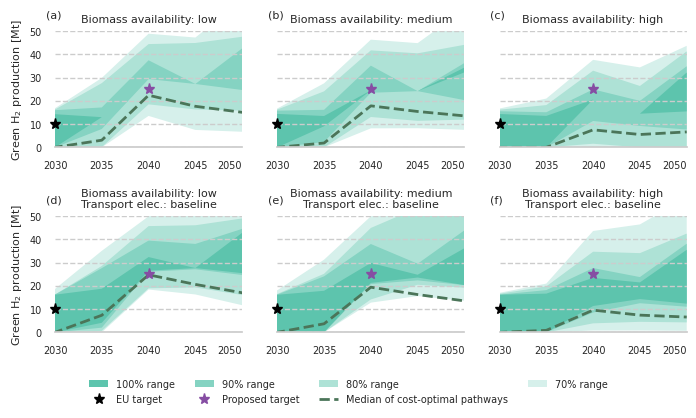

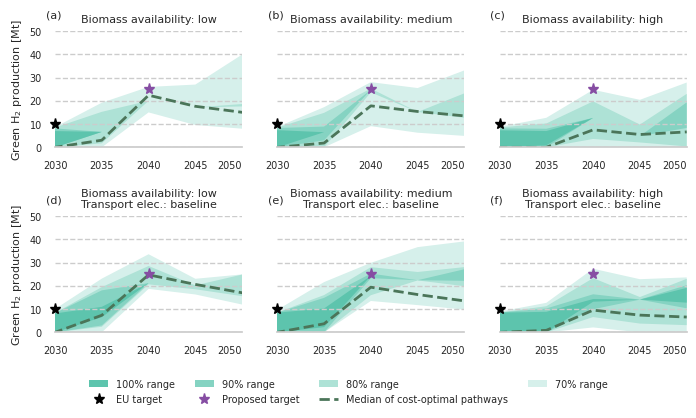

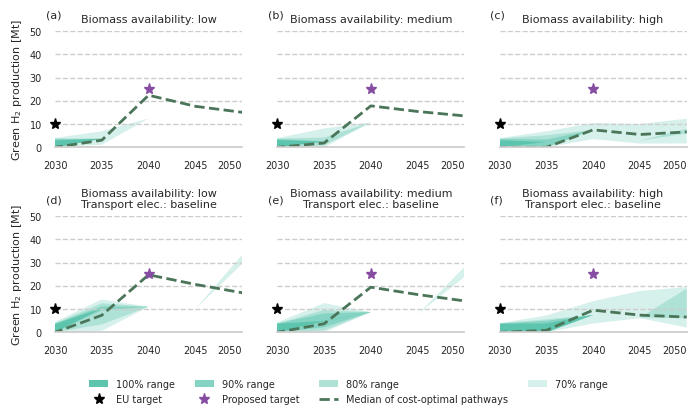

In [23]:
for slack_level in [0.1, 0.05, 0.02]:
    ncols = 3
    fig, axs = plt.subplots(
        2,
        ncols,
        figsize=(page_width, 9 * cm),
        sharey=True,
        layout="constrained",
        gridspec_kw={"hspace": 0.1, "wspace": 0.1},
    )

    quantiles = [0.7, 0.8, 0.9, 1]

    settings = {
        "pessimistic_biomass": {"B": "a"},
        "baseline_biomass": {"B": "b"},
        "optimistic_biomass": {"B": "c"},
        "pessimistic_biomass_base_trans": {"B": "a", "T": "b"},
        "baseline_biomass_base_trans": {"B": "b", "T": "b"},
        "optimistic_biomass_base_trans": {"B": "c", "T": "b"},
    }
    pretty_labels = {
        "pessimistic_biomass": "Biomass availability: low",
        "baseline_biomass": "Biomass availability: medium",
        "optimistic_biomass": "Biomass availability: high",
        "pessimistic_biomass_base_trans": "Biomass availability: low\nTransport elec.: baseline",
        "baseline_biomass_base_trans": "Biomass availability: medium\nTransport elec.: baseline",
        "optimistic_biomass_base_trans": "Biomass availability: high\nTransport elec.: baseline",
    }

    for ax, setting in zip(axs.flatten(), settings.values()):
        df_selection = df.copy()
        for level, value in setting.items():
            if isinstance(value, list):
                df_selection = df_selection.loc[
                    df_selection.index.get_level_values(level).isin(value)
                ]
            else:
                df_selection = df_selection.xs(value, level=level)
        plot_robust_ranges(
            df_selection,
            quantiles,
            slack_level,
            ax,
        )

    for ax in axs[:, 0]:
        ax.set_ylabel("Green H$_2$ production [Mt]", fontsize=textsize)

    ax = axs[0, 0]

    # Add a single legend underneath middle plot, with two entries: "Proposed targets" and "Cost-optimal pathway".
    # Have to make manual phantom line to get the legend to show the dashed line
    handles, labels = ax.get_legend_handles_labels()
    labels.append("Median of cost-optimal pathways")
    handles.append(ax.plot([], [], color=dark_green, linestyle="--", linewidth=2)[0])
    # Also add patches with quantile shading
    for q in quantiles:
        labels.insert(0, f"{q:.0%} range")
        handles.insert(
            0,
            ax.fill_between([], [], color=quantile_colors[q], edgecolor="none"),
        )
    # Reorder labels to put quantile shadings as every second item (bottom row)
    legend_cols = 4
    hl = list(zip(handles, labels))
    hl = sum([hl[i::legend_cols] for i in range(legend_cols)], [])

    fig.legend(
        *zip(*hl),
        loc="lower center",
        fontsize=labelsize,
        ncol=legend_cols,
        frameon=False,
        bbox_to_anchor=(0.5, -0.15),
    )

    # Plot titles
    for ax, setting in zip(axs.flatten(), settings):
        ax.set_title(pretty_labels[setting], fontsize=textsize)

    # Annotate the top left corner of each subplot with (a), (b), (c), etc.
    for i, ax in enumerate(axs.flatten()):
        ax.annotate(
            "(" + chr(97 + i) + ")",
            xy=(-0.05, 1.1),
            xycoords="axes fraction",
            fontsize=textsize,
            ha="left",
            va="bottom",
        )

    fig.savefig(
        f"figures/robustness_biomass_{slack_level}.pdf",
        dpi=300,
        bbox_inches="tight",
        transparent=True,
    )

    plt.show()

/tmp/ipykernel_1339243/3744467287.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


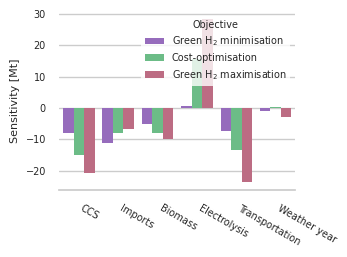

sense,a,b,min,opt,max
variable,,,,,
Electrolysis,(a),\ $\rightarrow$ (b),0.5,15.7,28.4
CCS,(a),\ $\rightarrow$ (c),-8.2,-15.1,-20.6
Transportation,(a),\ $\rightarrow$ (c),-7.3,-13.4,-23.6
Biomass,(a),\ $\rightarrow$ (c),-5.2,-8.1,-9.8
Imports,(a),\ $\rightarrow$ (b),-11.3,-8.0,-6.8
Weather year,(a),\ $\rightarrow$ (b),-1.0,0.3,-2.9


In [24]:
# Global sensitivity analysis

# for horizon in [2030, 2040, 2050]:
horizon = "2040-2050"

cols = ["C", "I", "B", "E", "T", "year"]
pretty_names = {
    "C": "CCS",
    "B": "Biomass",
    "I": "Imports",
    "E": "Electrolysis",
    "T": "Transportation",
    "year": "Weather year",
}

scenario_changes = {
    "C": ["(a)", "\\ $\\rightarrow$ (c)"],
    "B": ["(a)", "\\ $\\rightarrow$ (c)"],
    "I": ["(a)", "\\ $\\rightarrow$ (b)"],
    "E": ["(a)", "\\ $\\rightarrow$ (b)"],
    "T": ["(a)", "\\ $\\rightarrow$ (c)"],
    "year": ["(a)", "\\ $\\rightarrow$ (b)"],
}

results = pd.DataFrame(index=cols)

for sense in ["min", "opt", "max"]:

    selection = df.xs(sense, level="sense").copy()  #
    # selection = selection.xs(horizon, level="horizon").copy()
    selection = selection.loc[
        selection.index.get_level_values("horizon").isin([2040, 2045, 2050])
    ]
    selection = selection.xs(0.05, level="slack") if sense != "opt" else selection
    selection.reset_index(inplace=True)

    # Drop rows where h2prod is NaN
    selection = selection.dropna(subset=["h2prod"])

    # Multivariable linear regression of h2prod with chosen columns
    for col in cols:
        selection[col] = selection[col].map(
            {"a": 0, "b": 1, "1987": 0, "2020": 1}
            if col in ["E", "I", "year"]
            else {"a": 0, "b": 0.5, "c": 1}
        )

    X = selection[cols]
    X = X.astype(float)

    X = sm.add_constant(X)
    y = selection["h2prod"]

    model = sm.OLS(y, X).fit()

    results[sense] = model.params[1:]


# Barplot of coefficients
fig, ax = plt.subplots(figsize=(8 * cm, 7 * cm))

# Make wide-form
results = results.T.reset_index().melt(
    id_vars="index", var_name="variable", value_name="coefficient"
)
results.rename(columns={"index": "sense"}, inplace=True)

palette = {"min": min_c, "opt": green, "max": max_c}
sns.barplot(
    data=results,
    ax=ax,
    x="variable",
    y="coefficient",
    hue="sense",
    palette=palette,
    edgecolor="none",
)

# Set labels
ax.set_ylabel("Sensitivity [Mt]", fontsize=textsize)
ax.set_xlabel(None)

# Rename x-ticks
ax.set_xticklabels(
    [pretty_names[t.get_text()] for t in ax.get_xticklabels()], rotation=-30, ha="left"
)

# Tick fontsize
ax.tick_params(axis="both", which="major", labelsize=labelsize)

# Format legend entries "min" -> "Minimisation", etc.
patches, labels = ax.get_legend_handles_labels()
l = ax.legend(
    patches,
    ["Green H$_2$ minimisation", "Cost-optimisation", "Green H$_2$ maximisation"],
    title="Objective",
    title_fontsize=labelsize,
    fontsize=labelsize,
)
l.get_frame().set_linewidth(0.0)

# Turn off spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

fig.subplots_adjust(bottom=0.3, left=0.15, top=0.95)

plt.show()

# Pivot to make values of "sense" column to columns, "coefficients" as values
results = results.pivot(index="variable", columns="sense", values="coefficient")
# Add scenario changes as two columns
results["a"] = [scenario_changes[col][0] for col in results.index]
results["b"] = [scenario_changes[col][1] for col in results.index]
# Use pretty names
results.index = results.index.map(pretty_names)
# Sort rows by decrease absolute value of opt
results = results.sort_values("opt", key=abs, ascending=False)
# Round to 1 decimal
results = results.round(1)
# Order columns from min to max
results = results[["a", "b", "min", "opt", "max"]]
display(results)
results.to_csv(f"figures/sensitivity-{horizon}.csv")

# Demand for hydrogen

In [25]:
h2_demand_cols = list(filter(lambda x: x.startswith("demand:"), list(df.columns)))

In [26]:
pretty_names_h2_demand = {
    "demand:hydrogen for highT industry": "High-T industry heat",
    "demand:hydrogen for mediumT industry": "Medium-T industry heat",
    "demand:H2 Fuel Cell": "Fuel cells",
    "demand:Haber-Bosch": "Ammonia production",
    "demand:Sabatier": "Synthetic gas production",
    "demand:methanolisation": "Methanol production",
    "demand:Fischer-Tropsch": "Synthetic oil production",
    "demand:H2 for industry": "Industry",
    "demand:land transport fuel cell": "Transport",
}

colormap = {
    "High-T industry heat": config_default["plotting"]["tech_colors"]["highT industry"],
    "Medium-T industry heat": config_default["plotting"]["tech_colors"][
        "mediumT industry"
    ],
    "Fuel cells": config_default["plotting"]["tech_colors"]["H2 Fuel Cell"],
    "Ammonia production": config_default["plotting"]["tech_colors"]["Haber-Bosch"],
    "Synthetic gas production": config_default["plotting"]["tech_colors"]["Sabatier"],
    "Methanol production": config_default["plotting"]["tech_colors"]["methanolisation"],
    "Synthetic oil production": config_default["plotting"]["tech_colors"][
        "Fischer-Tropsch"
    ],
    "Industry": config_default["plotting"]["tech_colors"]["H2 for industry"],
    "Transport": config_default["plotting"]["tech_colors"]["land transport fuel cell"],
}

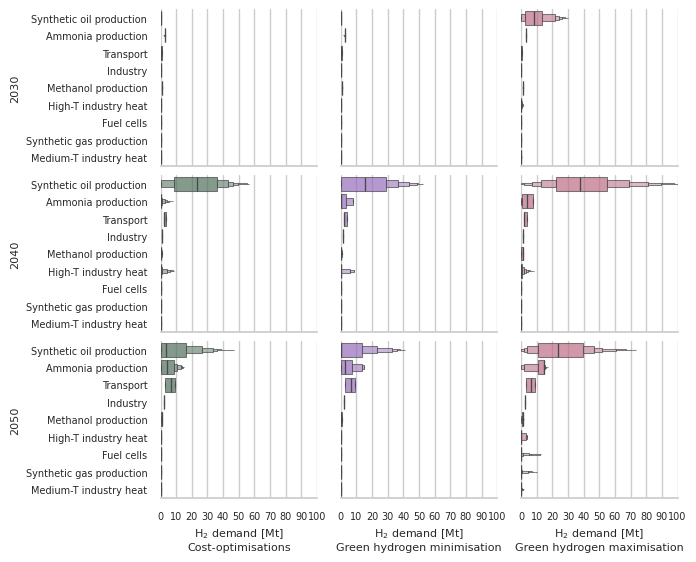

In [27]:
fig, axs = plt.subplots(
    3,
    3,
    sharex=True,
    sharey=True,
    gridspec_kw={"hspace": 0.05, "wspace": 0.05},
    figsize=(page_width, 14 * cm),
    layout="constrained",
)

for i, y in enumerate([2030, 2040, 2050]):
    for j, (sense, color) in enumerate(
        [("opt", dark_green), ("min", min_c), ("max", max_c)]
    ):
        ax = axs[i, j]

        h2_demand = (
            df.xs(y, level="horizon").xs(sense, level="sense")[h2_demand_cols].copy()
        )
        h2_demand = h2_demand.reindex(
            sorted(h2_demand.columns, key=lambda x: df[x].mean(), reverse=True),
            axis=1,
        )
        h2_demand = h2_demand.rename(columns=pretty_names_h2_demand) / (1e6 * 33.3)

        sns.boxenplot(
            data=h2_demand,
            orient="h",
            k_depth="full",
            color=color,
            alpha=0.7,
            ax=ax,
        )

        # Set labels
        sense_label = {
            "opt": "Cost-optimisations",
            "min": "Green hydrogen minimisation",
            "max": "Green hydrogen maximisation",
        }
        ax.set_xlabel(f"H$_2$ demand [Mt]\n{sense_label[sense]}", fontsize=textsize)
        ax.set_ylabel(f"{y}", fontsize=textsize)
        # Set tick sizes
        ax.tick_params(axis="both", which="major", labelsize=labelsize)
        # Turn off spines
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)

        # Set x axis limits
        ax.set_xlim(0, 100)

        # X ticks every 10
        ax.xaxis.set_major_locator(plt.MultipleLocator(10))

        # Turn off y tick labels for j > 0
        if j > 0:
            ax.tick_params(axis="y", which="both", labelleft=False)

        # Turn off x tick labels for i < 2
        if i < 2:
            ax.tick_params(axis="x", which="both", labelbottom=False)

plt.savefig(
    "figures/demand_total_h2.pdf",
    dpi=300,
    transparent=True,
)

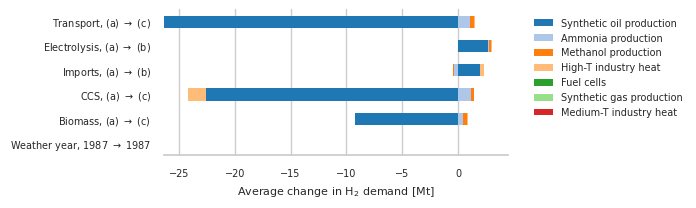

In [28]:
y = 2040

changes = {}

for o, (low, high) in [
    ("year", ("1987", "1987")),
    ("B", ("a", "c")),
    ("C", ("a", "c")),
    ("I", ("a", "b")),
    ("E", ("a", "b")),
    ("T", ("a", "c")),
]:

    h2_demand = (
        df.xs(y, level="horizon").xs("opt", level="sense")[h2_demand_cols].copy()
    )
    h2_demand = h2_demand.reindex(
        sorted(h2_demand.columns, key=lambda x: df[x].mean(), reverse=True),
        axis=1,
    )
    h2_demand = h2_demand.rename(columns=pretty_names_h2_demand) / (1e6 * 33.3)

    h2_demand = h2_demand.droplevel("scenario")

    change = (h2_demand.xs(high, level=o) - h2_demand.xs(low, level=o)).mean(axis=0)
    changes[o] = change

changes = pd.concat(changes, axis=1)

# pretty column names
scenario_dimensions = {
    "year": "Weather year, 1987 $\\rightarrow$ 1987",
    "B": "Biomass, (a) $\\rightarrow$ (c)",
    "C": "CCS, (a) $\\rightarrow$ (c)",
    "I": "Imports, (a) $\\rightarrow$ (b)",
    "E": "Electrolysis, (a) $\\rightarrow$ (b)",
    "T": "Transport, (a) $\\rightarrow$ (c)",
}
changes.rename(columns=scenario_dimensions, inplace=True)

# Remove the "Industry" and "Transport" rows since they are fixed demands
changes = changes.drop(["Industry", "Transport"])

fig, ax = plt.subplots(
    figsize=(page_width, 5 * cm),
    layout="constrained",
)
# tab20 colormap
changes.T.plot(
    kind="barh", stacked=True, linewidth=0, color=plt.color_sequences["tab20"], ax=ax
)

# Place legend on the right
ax.legend(
    loc="upper left",
    bbox_to_anchor=(1.05, 1),
    fontsize=labelsize,
    title_fontsize=labelsize,
    frameon=False,
)

# Set tick sizes
ax.tick_params(axis="both", which="major", labelsize=labelsize)

# Remove spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

# Remove y grid
ax.yaxis.grid(False)

# x axis label
ax.set_xlabel("Average change in H$_2$ demand [Mt]", fontsize=textsize)

plt.savefig(
    "figures/demand_scenario_changes.pdf",
    dpi=300,
    transparent=True,
)

# Map

INFO:pypsa.io:Imported network base_s_50_lc1.5__Ca-Ia-Ea-Tb_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


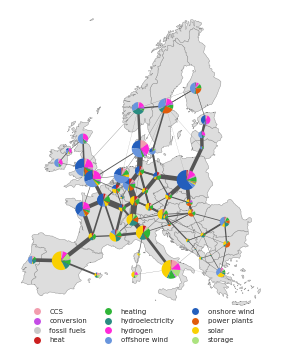

In [29]:
def assign_location(n):
    for c in n.iterate_components(n.one_port_components | n.branch_components):
        ifind = pd.Series(c.df.index.str.find(" ", start=4), c.df.index)
        for i in ifind.value_counts().index:
            # these have already been assigned defaults
            if i == -1:
                continue
            names = ifind.index[ifind == i]
            c.df.loc[names, "location"] = names.str[:i]


def rename_techs(label):
    prefix_to_remove = [
        "residential ",
        "services ",
        "urban ",
        "rural ",
        "central ",
        "decentral ",
    ]

    rename_if_contains = [
        "CHP",
        "gas boiler",
        "biogas",
        "solar thermal",
        "air heat pump",
        "ground heat pump",
        "resistive heater",
        "Fischer-Tropsch",
    ]

    rename_if_contains_dict = {
        "water tanks": "hot water storage",
        "retrofitting": "building retrofitting",
        "battery": "battery storage",
        "H2 for industry": "H2 for industry",
        "land transport fuel cell": "land transport fuel cell",
        "land transport oil": "land transport oil",
        "oil shipping": "shipping oil",
    }

    rename = {
        "solar": "solar PV",
        "Sabatier": "methanation",
        "offwind": "offshore wind",
        "offwind-ac": "offshore wind (AC)",
        "offwind-dc": "offshore wind (DC)",
        "offwind-float": "offshore wind (Float)",
        "onwind": "onshore wind",
        "ror": "hydroelectricity",
        "hydro": "hydroelectricity",
        "PHS": "hydroelectricity",
        "NH3": "ammonia",
        "co2 Store": "DAC",
        "co2 stored": "CO2 sequestration",
        "AC": "transmission lines",
        "DC": "transmission lines",
        "B2B": "transmission lines",
    }

    for ptr in prefix_to_remove:
        if label[: len(ptr)] == ptr:
            label = label[len(ptr) :]

    for rif in rename_if_contains:
        if rif in label:
            label = rif

    for old, new in rename_if_contains_dict.items():
        if old in label:
            label = new

    for old, new in rename.items():
        if old == label:
            label = new
    return label


def rename_techs_tyndp(tech):
    tech = rename_techs(tech)
    if tech == "solar PV":
        return "solar"
    elif "heat pump" in tech or "resistive heater" in tech:
        return "heating"
    elif tech in [
        "gas boiler",
        "biomass boiler",
        "gas for highT industry",
        "lowT industry methane",
    ]:
        return "heat"
    elif tech in [
        "H2 Electrolysis",
        "H2 liquefaction",
        "H2",
        "H2 Store",
        "H2 pipeline",
        "SMR",
        "hydrogen for highT industry",
    ]:
        return "hydrogen"
    elif tech in [
        "NH3",
        "Haber-Bosch",
        "ammonia cracker",
        "ammonia store",
        "biomass to liquid",
        "methanol",
    ]:
        return "conversion"
    elif tech in [
        "OCGT",
        "CHP",
        "H2 Fuel Cell",
        "coal",
        "lignite",
        "nuclear",
        "uranium",
        "allam",
    ]:
        return "power plants"
    elif tech in ["gas", "oil"]:
        return "fossil fuels"
    elif tech in ["Fischer-Tropsch", "methanolisation", "methanation", "Sabatier"]:
        return "conversion"
    elif "offshore wind" in tech:
        return "offshore wind"
    elif "CC" in tech or "sequestration" in tech:
        return "CCS"
    elif tech in ["DAC"]:
        return "CCS"
    elif tech in ["battery storage", "hot water storage"]:
        return "storage"
    else:
        return tech


preferred_order = pd.Index(
    [
        "onshore wind",
        "offshore wind",
        "solar",
        "hydroelectricity",
        "power plants",
        "heating",
        "conversion",
        "storage",
        "hydrogen",
        "CCS",
    ]
)

tech_colors = config_default["plotting"]["tech_colors"]
tech_colors["power plants"] = tech_colors["gas"]
tech_colors["conversion"] = tech_colors["methanation"]
tech_colors["heating"] = tech_colors["heat pump"]
tech_colors["storage"] = tech_colors["battery storage"]
tech_colors["hydrogen"] = tech_colors["H2 Electrolysis"]
tech_colors["fossil fuels"] = tech_colors["oil"]

n = pypsa.Network("networks/base_s_50_lc1.5__Ca-Ia-Ea-Tb_2050.nc")

assign_location(n)
n.buses.drop(n.buses.index[n.buses.carrier != "AC"], inplace=True)

# Manually move Croatia node a degree north-west
n.buses.loc[n.buses.index.str.startswith("HR"), "x"] -= 2
n.buses.loc[n.buses.index.str.startswith("HR"), "y"] += 2.1

costs = pd.DataFrame(index=n.buses.index)

for comp in ["links", "stores", "storage_units", "generators"]:
    df_c = getattr(n, comp)

    if df_c.empty:
        continue

    df_c["nice_group"] = df_c.carrier.map(rename_techs_tyndp)

    attr = "e_nom_opt" if comp == "stores" else "p_nom_opt"

    costs_c = (
        (df_c.capital_cost * df_c[attr])
        .groupby([df_c.location, df_c.nice_group])
        .sum()
        .unstack()
        .fillna(0.0)
    )
    costs = pd.concat([costs, costs_c], axis=1)

costs = costs.T.groupby(costs.columns).sum().T

costs.drop(list(costs.columns[(costs == 0.0).all()]), axis=1, inplace=True)

new_columns = preferred_order.intersection(costs.columns).append(
    costs.columns.difference(preferred_order)
)
costs = costs[new_columns]

costs = costs.stack()  # .sort_index()

to_drop = costs.index.levels[0].symmetric_difference(n.buses.index)
if len(to_drop) != 0:
    costs.drop(to_drop, level=0, inplace=True, axis=0, errors="ignore")

# make sure they are removed from index
costs.index = pd.MultiIndex.from_tuples(costs.index.values)

threshold = 100e6  # 100 mEUR/a
carriers = costs.groupby(level=1).sum()
carriers = carriers.where(carriers > threshold).dropna()
carriers = list(carriers.index)


proj = ccrs.LambertConformal(
    central_longitude=10, central_latitude=50, standard_parallels=(35, 65)
)
fig, ax = plt.subplots(figsize=(18 * cm, 10 * cm), subplot_kw={"projection": proj})

bus_collection, _, _ = n.plot(
    ax=ax,
    bus_sizes=costs / 2e10,
    bus_colors=tech_colors,
    line_widths=n.lines.s_nom_opt / 8e3,
    line_colors="#555555",
    link_widths=n.links.p_nom_opt / 8e3,
    link_colors="#555555",
    color_geomap=False,
)
bus_collection.set_linewidth(0)

# Add legend
handles = [
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=tech_colors[tech])
    for tech in carriers
]
labels = carriers
l = ax.legend(
    handles,
    labels,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.12),
    fontsize=labelsize - 2,
    title="",
    ncol=3,
    frameon=False,
)


countries = config["countries"]  # Two letter country codes
# Convert to three-letter country codes
countries = [pycountry.countries.get(alpha_2=c).alpha_3 for c in countries]
# For each country, retrieve its shape and shade its area grey. Get their shapes from the Natural Earth dataset.
shpfilename = shpreader.natural_earth(
    resolution="50m", category="cultural", name="admin_0_countries"
)
shapes = shpreader.Reader(shpfilename).records()
for shape in shapes:
    if shape.attributes["ADM0_A3"] in countries:
        ax.add_geometries(
            [shape.geometry],
            ccrs.PlateCarree(),
            facecolor="#dddddd",
            edgecolor="#888888",
            linewidth=0.3,
        )


# Axis boundaries: Europe
ax.set_extent([-10, 30, 35, 72], crs=ccrs.PlateCarree())

# Save as pdf
plt.savefig("figures/map.pdf", dpi=300, bbox_inches="tight", transparent=True)

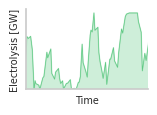

In [30]:
# Simple plot of total electrolysis production
fig, ax = plt.subplots(figsize=(4 * cm, 3 * cm))
elec_i = n.links.loc[n.links.carrier == "H2 Electrolysis"].index
elec = -n.links_t.p1.loc[:, elec_i].sum(axis=1) / 1e3
elec.plot(ax=ax, color=green, linewidth=0.5)
# Fill in the area under the curve
ax.fill_between(elec.index, elec, color=green, alpha=0.3)

# Set limits
ax.set_ylim(bottom=0)
# x: feb. 2020
ax.set_xlim(pd.Timestamp("1987-03-01"), pd.Timestamp("1987-04-01"))

# Remove all ticks
ax.set_xticks([])
ax.set_yticks([])

# Remove spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Remove grid
ax.grid(False)

# Axis labels
ax.set_ylabel("Electrolysis [GW]", fontsize=labelsize)
ax.set_xlabel("Time", fontsize=labelsize)

plt.savefig("figures/h2_prod_small.pdf", dpi=300, bbox_inches="tight", transparent=True)

# Hydrogen prices and subsidies

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


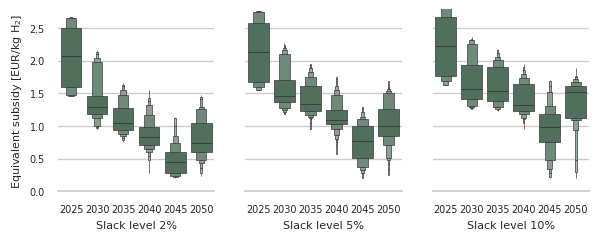

In [31]:
# Dual variables of system cost constraints of maximisation
values = -df.xs("max", level="sense").obj_bound_dual.copy()
# Correct for scaling of the objective bound
values = values * float(config["near_opt"]["obj_bound_scaling_factor"])
# Values are in MWh / EUR. Convert to kg H2 / EUR
kgH2_per_MWh = 1000 / 33.3
values *= kgH2_per_MWh
# Filter out values above 5: these are probably due to numerical instability
values = values[(values < 5) & (values > 0)].dropna()
# Convert to EUR / kg H2
values = 1 / values

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(page_width, 6 * cm))

# Boxen plot of values df by horizon
for ax, slack in zip(axs, [0.02, 0.05, 0.1]):
    sns.boxenplot(
        data=values.xs(slack, level="slack").reset_index(),
        x="horizon",
        y="obj_bound_dual",
        orient="v",
        k_depth="full",
        color=dark_green,
        linewidth=0.5,
        ax=ax,
    )

    ax.set_ylim(bottom=0)

    # Set labels
    ax.set_ylabel("Equivalent subsidy [EUR/kg H$_2$]", fontsize=textsize)
    ax.set_xlabel(f"Slack level {slack:.0%}", fontsize=textsize)

    # Tick label size
    ax.tick_params(axis="both", which="major", labelsize=labelsize)

    # Remove spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

In [32]:
# Try to calculate the amount and level of subsidy required to reach a certain
# hydrogen production target, based on the dual variables of the system cost
# constraints

target_year = targets[0][0]
target_h2 = targets[0][1]
df_sel = df.xs(target_year, level="horizon").xs("opt", level="sense").copy()
df_sel = df_sel.droplevel("slack")

# subsidy level in EUR/kg H2, subsidy amount in bn EUR
# (note: Mt of H2 cancel with bn EUR (both 1e9 multipliers))
df_sub = pd.DataFrame(
    index=df_sel.index,
    columns=["subsidy_level", "subsidy_amount", "slack"],
    dtype=np.float64,
)

for i, row in df_sel.iterrows():
    # Is the current system below or above target?
    if row.h2prod < target_h2:
        prev_h2 = row.h2prod
        prev_sub = 0
        # Iterate through slack levels to find if any h2 maximisation went above target.
        for s in [0.02, 0.05, 0.1]:
            next_max = (
                df.xs(target_year, level="horizon")
                .xs("max", level="sense")
                .xs(s, level="slack")
                .loc[i]
            )
            if next_max.h2prod >= target_h2:
                # Get the dual variable for this slack level
                values_sel = values.xs(target_year, level="horizon").xs(
                    s, level="slack"
                )
                if i in values_sel.index:
                    # Get the subsidy level for this slack level
                    sub = values_sel.loc[i]
                else:
                    continue
                # Weighted average of sub and the previous subsidy
                frac = (target_h2 - prev_h2) / (next_max.h2prod - prev_h2)
                subsidy_level = frac * sub + (1 - frac) * prev_sub
                # Calculate the subsidy amount
                subsidy_amount = subsidy_level * target_h2
                # Add to df
                df_sub.loc[i] = [subsidy_level, subsidy_amount, s]
                break
        else:
            # Extrapolate from 10% slack level
            subsidy_level = sub
            subsidy_amount = sub * target_h2
            df_sub.loc[i] = [subsidy_level, subsidy_amount, 0.15]
    else:
        # If the system is above target, set subsidy to 0
        df_sub.loc[i] = [0, 0, 0]

In [33]:
# Estimate the total increase in system cost due to the subsidies. This can be
# done similarly to the subsidy level calcalation but using system cost instead.

target_year = targets[0][0]
target_h2 = targets[0][1]
df_sel = df.xs(target_year, level="horizon").xs("opt", level="sense").copy()
df_sel = df_sel.droplevel("slack")

# subsidy level in EUR/kg H2, subsidy amount in bn EUR
# (note: Mt of H2 cancel with bn EUR (both 1e9 multipliers))
df_sub_upper = pd.DataFrame(
    index=df_sel.index,
    columns=["subsidy_level", "subsidy_amount", "slack"],
    dtype=np.float64,
)

for i, row in df_sel.iterrows():
    # Is the current system below or above target?
    if row.h2prod < target_h2:
        # Iterate through slack levels to find if any h2 maximisation went above target.
        for s in [0.02, 0.05, 0.1]:
            next_max = (
                df.xs(target_year, level="horizon")
                .xs("max", level="sense")
                .xs(s, level="slack")
                .loc[i]
            )
            if next_max.h2prod >= target_h2:
                # Find how far along to next_max.h2prod the target is
                frac = (target_h2 - row.h2prod) / (next_max.h2prod - row.h2prod)
                subsidy_amount = frac * s * row.system_cost / 1e9
                subsidy_level = subsidy_amount / target_h2
                # Add to df
                df_sub_upper.loc[i] = [subsidy_level, subsidy_amount, s]
                break
        else:
            # Extrapolate from 10% slack level
            frac = (target_h2 - row.h2prod) / (next_max.h2prod - row.h2prod)
            subsidy_amount = frac * s * row.system_cost / 1e9
            subsidy_level = subsidy_amount / target_h2
            df_sub_upper.loc[i] = [subsidy_level, subsidy_amount, 0.15]
    else:
        # If the system is above target, set subsidy to 0
        df_sub_upper.loc[i] = [0, 0, 0]

In [34]:
print("Estimation of subsidies:")
display(df_sub.dropna().describe().round(2))

print("Estimation of impact on system cost:")
display(df_sub_upper.dropna().describe().round(2))

print("Total system cost premium [%]:")
display(((df_sub_upper / df_sub - 1) * 100).dropna().mean().round(0).subsidy_level)

Estimation of subsidies:


,subsidy_level,subsidy_amount,slack
count,216.00,216.00,216.00
mean,0.55,13.69,0.04
std,0.54,13.49,0.04
min,0.00,0.00,0.00
25%,0.00,0.00,0.00
50%,0.56,13.89,0.02
75%,0.92,23.06,0.05
max,1.87,46.66,0.15


Estimation of impact on system cost:


,subsidy_level,subsidy_amount,slack
count,216.00,216.00,216.00
mean,0.96,24.00,0.04
std,1.10,27.39,0.04
min,0.00,0.00,0.00
25%,0.00,0.00,0.00
50%,0.46,11.58,0.02
75%,1.73,43.13,0.05
max,4.47,111.65,0.15


Total system cost premium [%]:


57.0

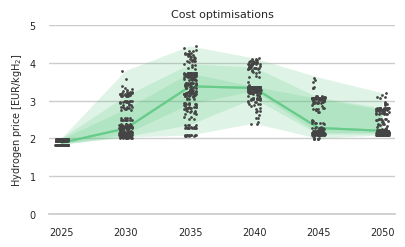

In [35]:
# Evolution of h2 price

fig, ax = plt.subplots(figsize=(10 * cm, 6 * cm), layout="constrained")

per_mwh_to_per_kg = 33.3 / 1e3

df_copy = df.copy()
df_copy.h2price = df_copy.h2price * per_mwh_to_per_kg

sns.stripplot(
    data=df_copy.xs("opt", level="sense"),
    x="horizon",
    y="h2price",
    orient="v",
    native_scale=True,
    color="#444444",
    ax=ax,
    s=2,
)

for quantile, alpha in zip([100, 75, 50], [0.3, 0.5, 0.7]):
    sns.lineplot(
        data=df_copy.xs("opt", level="sense"),
        x="horizon",
        y="h2price",
        color=green,
        estimator=np.median,
        errorbar=("pi", quantile),
        err_kws={"edgecolor": "none"},
        alpha=alpha,
        ax=ax,
    )

ax.set_ylim(bottom=0, top=5)
ax.set_xlim(2024, 2051)

# Turn off x-grid
ax.xaxis.grid(False)

# Turn off spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

# Set labels
ax.set_ylabel("Hydrogen price [EUR/kgH$_2$]", fontsize=labelsize)
ax.set_xlabel(None)

# Tick font
ax.tick_params(axis="both", which="major", labelsize=labelsize)

ax.set_title("Cost optimisations", fontsize=textsize)

plt.savefig("figures/h2price.pdf", dpi=300, transparent=True)

# CCS & Imports

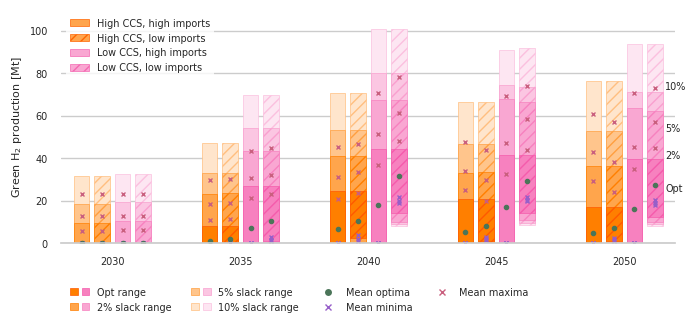

In [36]:
# Plot vertical bars going from minimum to maximum value of h2prod. One group of
# bars for each time horizon. Each group consists of four bars, one for each
# combination of CCS and imports scenario.

fig, ax = plt.subplots(figsize=(page_width, 8 * cm), layout="constrained")

scenarios_to_plot = [
    ({"C": "c", "I": "b"}, "High CCS, high imports", plt.get_cmap("Set1")(4), dict()),
    (
        {"C": "c", "I": "a"},
        "High CCS, low imports",
        plt.get_cmap("Set1")(4),
        dict(hatch="///"),
    ),
    ({"C": "a", "I": "b"}, "Low CCS, high imports", plt.get_cmap("Set1")(7), dict()),
    (
        {"C": "a", "I": "a"},
        "Low CCS, low imports",
        plt.get_cmap("Set1")(7),
        dict(hatch="///"),
    ),
]

lighten_by_slack = {
    0.0: 0.0,
    0.02: 0.3,
    0.05: 0.55,
    0.1: 0.8,
}

rect_style = dict(
    linewidth=0.5,
)

bar_width = 0.6  # in years
bar_gap = 0.2  # in years


def plot_bars(ax, mark_min=False):
    for y in df.index.get_level_values("horizon").unique():
        # Get the data for the current time horizon
        data = df.xs(level="horizon", key=y).xs("b", level="T")

        # For each slack level
        for slack in reversed(
            data.index.get_level_values("slack").unique().sort_values()
        ):
            # Get the data for the current slack level
            data_slack = data.xs(level="slack", key=slack)

            # For each combination of CCS and imports
            for j, (S, label, color, attrs) in enumerate(scenarios_to_plot):
                # Get the data for the current combination of CCS and imports
                d = data_slack
                for k, v in S.items():
                    d = d.xs(v, level=k)

                # Plot a rectangle from min to max h2prod
                ax.add_patch(
                    plt.Rectangle(
                        (
                            y + (j - 2) * (bar_width + bar_gap) + bar_gap / 2,
                            d.h2prod.min(),
                        ),
                        bar_width,
                        d.h2prod.max() - d.h2prod.min(),
                        facecolor=lighten_color(color, lighten_by_slack[slack]),
                        edgecolor=lighten_color(color, lighten_by_slack[slack] - 0.3),
                        **rect_style,
                        **attrs,
                    )
                )

                # Add a dot showing the mean value of opt, min and max h2prod
                if slack == 0.0:
                    ax.plot(
                        y
                        + (j - 2) * (bar_width + bar_gap)
                        + bar_gap / 2
                        + bar_width / 2,
                        d.xs("opt", level="sense").h2prod.mean(),
                        marker="o",
                        color=dark_green,
                        linewidth=0,
                        markersize=3,
                    )
                else:
                    for sense, color in zip(["min", "max"], [min_c, max_c]):
                        ax.plot(
                            y
                            + (j - 2) * (bar_width + bar_gap)
                            + bar_gap / 2
                            + bar_width / 2,
                            d.xs(sense, level="sense").h2prod.mean(),
                            marker="x",
                            color=color,
                            linewidth=0,
                            markersize=3,
                        )

                if mark_min and slack == 0.02:
                    # Place a star at minimum value of h2prod in the 0.02 slack scenario
                    ax.plot(
                        y
                        + (j - 2) * (bar_width + bar_gap)
                        + bar_gap / 2
                        + bar_width / 2,
                        d.h2prod.min(),
                        marker="x",
                        color=min_c,
                        markersize=6,
                    )


plot_bars(ax)


# Add text annotations for slack level at max h2prod value in last scenario of
# last time horizon. Add text just below and to the right of h2prod value.
def annotate_slack(ax, y, sense):
    for slack in reversed(df.index.get_level_values("slack").unique().sort_values()):
        d = df.xs(level="slack", key=slack)
        (S, label, color, attrs) = scenarios_to_plot[-1]
        d_slack = d.xs(level="horizon", key=y)
        for k, v in S.items():
            d_slack = d_slack.xs(v, level=k)
        # Annotation at (y, d_slack.h2prod.max()), offset 3pts down and right
        # h = d_slack.h2prod.max() if sense == "max" else d_slack.h2prod.min()
        h = (
            d_slack.xs(sense, level="sense").h2prod.mean()
            if slack > 0
            else d_slack.h2prod.mean()
        )
        ax.annotate(
            f"{slack:.0%}" if slack > 0 else "Opt",
            xy=(y + 2 * bar_width + 1.5 * bar_gap, h),
            xytext=(2, -2) if sense == "max" else (2, 2),
            textcoords="offset points",
            va="center",  # "top" if sense == "max" else "bottom",
            ha="left",
            size=labelsize,
            # Background color
            bbox=dict(facecolor="white", edgecolor="none", boxstyle="round,pad=0.1"),
        )


annotate_slack(ax, 2050, "max")


# Set limits
ax.set_ylim(bottom=0, top=H2_MAX)
ax.set_xlim(2028, 2052)

# Legend
handles = [
    plt.Rectangle(
        (0, 0),
        1,
        1,
        facecolor=lighten_color(color, 0.3),
        edgecolor=lighten_color(color, -0.2),
        **rect_style,
        **attrs,
    )
    for _, _, color, attrs in scenarios_to_plot
]
labels = [label for _, label, _, _ in scenarios_to_plot]
l = ax.legend(handles, labels, loc="upper left", fontsize=labelsize, edgecolor="none")
ax.add_artist(l)

# Add a second legend, located underneath the main axis, with the dot and
# crosses for mean opt, min, max values as well as shaded boxes for opt, 2%, 5%
# and 10% ranges.
handles = [
    tuple(
        plt.Rectangle(
            (0, 0),
            1,
            1,
            facecolor=lighten_color(color, lightness),
            edgecolor=lighten_color(color, lightness - 0.3),
            **rect_style,
            label=re.sub(r"^0% slack", "Opt", f"{slack:.0%} slack range"),
        )
        for color in [plt.get_cmap("Set1")(4), plt.get_cmap("Set1")(7)]
    )
    for slack, lightness in lighten_by_slack.items()
] + [
    # Markers
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="none",
        markerfacecolor=dark_green,
        markeredgewidth=0,
        markersize=5,
        label="Mean optima",
    ),
    plt.Line2D(
        [0],
        [0],
        marker="x",
        color="none",
        markeredgecolor=min_c,
        markersize=5,
        label="Mean minima",
    ),
    plt.Line2D(
        [0],
        [0],
        marker="x",
        color="none",
        markeredgecolor=max_c,
        markersize=5,
        label="Mean maxima",
    ),
]

labels = [
    re.sub(r"^0% slack", "Opt", f"{slack:.0%} slack range")
    for slack in lighten_by_slack.keys()
] + ["Mean optima", "Mean minima", "Mean maxima"]

ax.legend(
    handles=handles,
    labels=labels,
    fontsize=labelsize,
    ncol=4,
    loc="upper left",
    bbox_to_anchor=(0.0, -0.15),
    frameon=False,
    # Use HandlerTuple to join items with the same label
    handler_map={tuple: HandlerTuple(ndivide=None)},
)

# Size of tick labels
ax.tick_params(axis="both", which="major", labelsize=labelsize)

# Turn off x-grid
ax.xaxis.grid(False)

# Turn off spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

# Y label
ax.set_ylabel("Green H$_2$ production [Mt]", fontsize=textsize)

# Save
plt.savefig("figures/CCS_imports_bars.pdf", dpi=300, transparent=True)
plt.show()

In [37]:
# Show minimum h2prod across slack levels for each combination of CCS and imports scenario
df_min = (
    df.xs("min", level="sense")
    .xs("b", level="T")
    .groupby(["I", "C", "horizon"])
    .h2prod.min()
    .unstack()
)
display(df_min)

horizon  2025  2030  2035      2040      2045      2050
I C                                                    
a a      -0.0  -0.0  -0.0  8.204589  8.788763  8.346840
  b      -0.0  -0.0  -0.0  0.798520  0.803850  0.661552
  c      -0.0  -0.0  -0.0 -0.000000 -0.000000 -0.000000
b a      -0.0  -0.0  -0.0 -0.000000 -0.000000 -0.000000
  b      -0.0  -0.0  -0.0 -0.000000 -0.000000 -0.000000
  c      -0.0  -0.0  -0.0 -0.000000 -0.000000 -0.000000

In [38]:
# Gather those scenarios wher minimum h2prod is strictly positive
df_min = (
    df.xs("min", level="sense")
    .xs(0.1, level="slack")
    .xs(2040, level="horizon")
    .h2prod.dropna()
)
df_min = df_min[df_min > 5]
for c in ["B", "C", "I", "E", "T"]:
    display(df_min.index.get_level_values(c).value_counts())

B
a    28
b    24
c    12
Name: count, dtype: int64

C
a    32
b    24
c     8
Name: count, dtype: int64

I
a    64
Name: count, dtype: int64

E
a    32
b    32
Name: count, dtype: int64

T
a    32
b    20
c    12
Name: count, dtype: int64

# Correlations

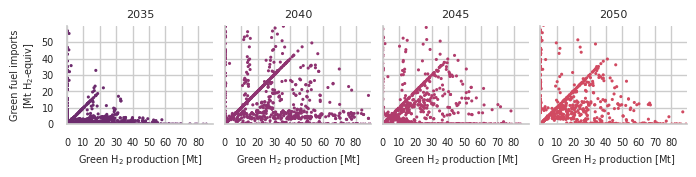

In [39]:
# Scatter plot of h2prod against imports

horizons = [2035, 2040, 2045, 2050]

# Horizon palette based on Set2
horizon_palette = {y: sns.color_palette("flare_r")[i] for i, y in enumerate(horizons)}

fig, axs = plt.subplots(
    1,
    len(horizons),
    figsize=(page_width, 6 * cm),
    layout="constrained",
    sharey=True,
    sharex=True,
)

df_imports = df.copy()
df_imports.imports = df.imports / 33.3

for i, (horizon, color) in enumerate(horizon_palette.items()):
    # Scatter plot of h2prod against imports
    ax = axs[i]
    ax.set_title(f"{horizon}", fontsize=textsize)

    # Scatter plot for all values with non-zero imports
    data = df_imports.xs(horizon, level="horizon").copy()

    data.plot(
        kind="scatter",
        x="h2prod",
        y="imports",
        color=color,
        ax=ax,
        s=5,
        edgecolor="none",
    )

    ax.set_ylim(bottom=0)
    ax.set_xlim(left=0)

    # Set labels
    ax.set_xlabel("Green H$_2$ production [Mt]", fontsize=labelsize)
    ax.set_ylabel(None)

    # Set ticks
    ax.tick_params(axis="both", which="major", labelsize=labelsize)

    # Spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Equal aspect ratio
    ax.set_aspect("equal")

    # Grid at 10 Mt intervals
    ax.xaxis.set_major_locator(plt.MultipleLocator(10))
    ax.yaxis.set_major_locator(plt.MultipleLocator(10))

axs[0].set_ylabel("Green fuel imports\n[Mt H$_2$-equiv]", fontsize=labelsize)

plt.savefig("figures/h2prod_imports.pdf", dpi=300, transparent=True)

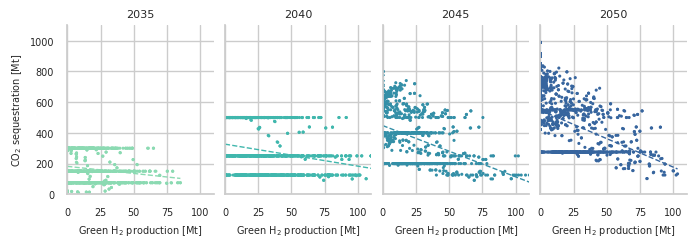

In [40]:
# Scatter plot of h2prod against carbon sequestration

horizons = [2035, 2040, 2045, 2050]

# Horizon palette based on Set2
horizon_palette = {y: sns.color_palette("mako_r")[i] for i, y in enumerate(horizons)}

fig, axs = plt.subplots(
    1,
    len(horizons),
    figsize=(page_width, 6 * cm),
    layout="constrained",
    sharey=True,
    sharex=True,
)

df_copy = df.copy()
df_copy.co2seq = df.co2seq / 1e6

for i, (horizon, color) in enumerate(horizon_palette.items()):
    ax = axs[i]
    ax.set_title(f"{horizon}", fontsize=textsize)

    data = df_copy.xs(horizon, level="horizon").copy()
    sns.scatterplot(
        data=data,
        x="h2prod",
        y="co2seq",
        color=color,
        ax=ax,
        s=5,
        edgecolor="none",
    )

    # For each horizon, plot a line of best fit for all values with non-zero imports
    sns.regplot(
        data=data,
        x="h2prod",
        y="co2seq",
        scatter=False,
        ax=ax,
        color=color,
        line_kws={"linestyle": "--", "linewidth": 1},
        ci=None,
    )

    ax.set_ylim(bottom=0, top=1100)
    ax.set_xlim(left=0, right=H2_MAX)

    # Set labels
    ax.set_xlabel("Green H$_2$ production [Mt]", fontsize=labelsize)

    # Set ticks
    ax.tick_params(axis="both", which="major", labelsize=labelsize)

    # Spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# Grid at 10 Mt intervals
# ax.xaxis.set_major_locator(plt.MultipleLocator(10))
# ax.yaxis.set_major_locator(plt.MultipleLocator(10))

axs[0].set_ylabel("CO$_2$ sequestration [Mt]", fontsize=labelsize)

plt.savefig("figures/h2prod_seq.pdf", dpi=300, transparent=True)

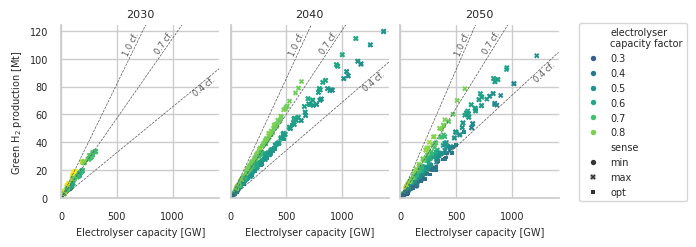

In [41]:
# Scatter plot of h2prod against electolyser capacity

# Horizon palette based on Set2
horizon_palette = {
    y: sns.color_palette("Set3")[i]
    for i, y in enumerate(df.index.get_level_values("horizon").unique())
}

fig, axs = plt.subplots(
    1, 3, figsize=(page_width, 6 * cm), sharey=True, sharex=True, layout="constrained"
)

df_elec = df.copy()
df_elec.elec_cap = df_elec.elec_cap / 1e3  # Convert to GW

# Norm for colourscale based on elec_cf
norm = mpl.colors.Normalize(vmin=df_elec.elec_cf.min(), vmax=df_elec.elec_cf.max())

for i, h in enumerate([2030, 2040, 2050]):
    sns.scatterplot(
        data=df_elec.xs("b", level="B").xs(h, level="horizon"),
        x="elec_cap",
        y="h2prod",
        hue="elec_cf",
        palette="viridis",
        hue_norm=norm,
        style="sense",
        ax=axs[i],
        s=15,
        edgecolor="none",
    )

    # Plot dotted lines indicating capacity factors
    costs = pd.read_csv(f"../resources/Y1987_Bb/costs_{h}.csv", index_col=[0, 1])
    efficiency = costs.loc[("electrolysis", "efficiency"), "value"]
    x_max, y_max = df_elec.elec_cap.max(), df_elec.h2prod.max()
    x = x_max
    for cf in [0.4, 0.7, 1.0]:
        y = x * 8760 * efficiency * cf / 33.3 / 1e3
        axs[i].plot([0, x], [0, y], linestyle="--", color="#555555", linewidth=0.5)
        # Annotation of the line; place at the edge of the plotting region.
        # First, find the intersection of the line with the spines of the plot.
        x_intercept = x_max if y < y_max else x_max * (y_max / y)
        y_intercept = y if y < y_max else y_max
        axs[i].text(
            0.95 * x_intercept,
            0.95 * y_intercept,
            f"{cf} cf.",
            va="bottom" if cf > 0.4 else "top",
            ha="right",
            # Rotation based on the angle of the line, but convert axis coordinates to figure coordinates
            rotation=np.degrees(np.arctan(y / x)),
            rotation_mode="anchor",
            transform_rotates_text=True,
            color="#555555",
            fontsize=labelsize - 1,
        )

for ax in axs:
    ax.set_ylim(bottom=0, top=df_elec.h2prod.max())
    ax.set_xlim(left=0, right=df_elec.elec_cap.max())

    # Set labels
    ax.set_xlabel("Electrolyser capacity [GW]", fontsize=labelsize)
    ax.set_ylabel("Green H$_2$ production [Mt]", fontsize=labelsize)

    # Set ticks
    ax.tick_params(axis="both", which="major", labelsize=labelsize)

    # Spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# Legend to the right of the last plot
l = axs[-1].legend(
    fontsize=labelsize,
    # title="Capacity factor",
    # title_fontsize=labelsize,
    loc="center left",
    bbox_to_anchor=(1.1, 0.5),
)

# Rename "elec_cf" to "Capacity factor" in the legend
l.get_texts()[0].set_text("electrolyser\ncapacity factor")

# Disable legends for the other two plots
for ax in axs[:-1]:
    ax.get_legend().remove()

# Titles
for i, h in enumerate([2030, 2040, 2050]):
    axs[i].set_title(f"{h}", fontsize=textsize)

plt.savefig("figures/h2prod_elec_cap.pdf", dpi=300, transparent=True)

# Evolution of other technologies

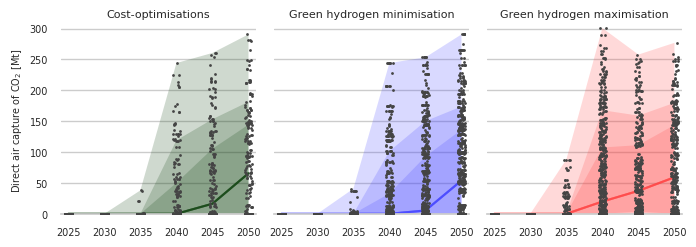

In [42]:
# DAC

fig, axs = plt.subplots(
    1, 3, figsize=(page_width, 6 * cm), sharey=True, layout="constrained"
)

palette = {"opt": "#114411", "min": "#4444ff55", "max": "#ff444455"}

# Sense pretty names
sense_pretty = {
    "opt": "Cost-optimisations",
    "min": "Green hydrogen minimisation",
    "max": "Green hydrogen maximisation",
}

for i, sense in enumerate(["opt", "min", "max"]):
    ax = axs[i]

    # First a scatter-plot of dac
    sns.stripplot(
        data=df.xs(sense, level="sense") / 1e6,
        x="horizon",
        y="dac",
        orient="v",
        native_scale=True,
        color="#444444",
        ax=ax,
        s=2,
    )

    for quantile, alpha in zip([100, 75, 50], [0.3, 0.5, 0.7]):
        sns.lineplot(
            data=df.xs(sense, level="sense") / 1e6,
            x="horizon",
            y="dac",
            color=palette[sense],
            estimator=np.median,
            errorbar=("pi", quantile),
            err_kws={"edgecolor": "none"},
            alpha=alpha,
            ax=ax,
        )

    ax.set_ylim(bottom=0)
    ax.set_xlim(2024, 2051)

    # Turn off x-grid
    ax.xaxis.grid(False)

    # Turn off spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

    # Set labels
    ax.set_ylabel("Direct air capture of CO$_2$ [Mt]", fontsize=labelsize)
    ax.set_xlabel(None)

    # Tick font
    ax.tick_params(axis="both", which="major", labelsize=labelsize)

    ax.set_title(sense_pretty[sense], fontsize=textsize)

plt.savefig("figures/DAC.pdf", dpi=300, transparent=True)

In [43]:
# Display interquantile range of cost-opt DAC
display(
    (
        df.xs("opt", level="sense")
        .groupby("horizon")
        .dac.quantile([0.25, 0.5, 0.75])
        .unstack()
        / 1e6
    ).round(0)
)

display(
    (
        df.xs("max", level="sense")
        .groupby("horizon")
        .dac.quantile([0.25, 0.5, 0.75])
        .unstack()
        / 1e6
    ).round(0)
)

,0.25,0.50,0.75
horizon,,,
2025,0.0,0.0,0.0
2030,0.0,0.0,0.0
2035,0.0,0.0,0.0
2040,0.0,0.0,50.0
2045,0.0,16.0,105.0
2050,0.0,66.0,144.0


,0.25,0.50,0.75
horizon,,,
2025,0.0,0.0,0.0
2030,0.0,0.0,0.0
2035,0.0,0.0,0.0
2040,0.0,20.0,107.0
2045,4.0,37.0,111.0
2050,0.0,59.0,144.0


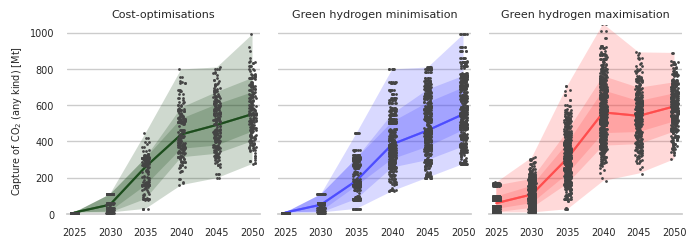

In [44]:
# Carbon capture of any kind

fig, axs = plt.subplots(
    1, 3, figsize=(page_width, 6 * cm), sharey=True, layout="constrained"
)

palette = {"opt": "#114411", "min": "#4444ff55", "max": "#ff444455"}

# Sense pretty names
sense_pretty = {
    "opt": "Cost-optimisations",
    "min": "Green hydrogen minimisation",
    "max": "Green hydrogen maximisation",
}

for i, sense in enumerate(["opt", "min", "max"]):
    ax = axs[i]

    # First a scatter-plot of dac
    sns.stripplot(
        data=df.xs(sense, level="sense"),
        x="horizon",
        y="captured_co2",
        orient="v",
        native_scale=True,
        color="#444444",
        ax=ax,
        s=2,
    )

    for quantile, alpha in zip([100, 75, 50], [0.3, 0.5, 0.7]):
        sns.lineplot(
            data=df.xs(sense, level="sense"),
            x="horizon",
            y="captured_co2",
            color=palette[sense],
            estimator=np.median,
            errorbar=("pi", quantile),
            err_kws={"edgecolor": "none"},
            alpha=alpha,
            ax=ax,
        )

    ax.set_ylim(bottom=0)
    ax.set_xlim(2024, 2051)

    # Turn off x-grid
    ax.xaxis.grid(False)

    # Turn off spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

    # Set labels
    ax.set_ylabel("Capture of CO$_2$ (any kind) [Mt]", fontsize=labelsize)
    ax.set_xlabel(None)

    # Tick font
    ax.tick_params(axis="both", which="major", labelsize=labelsize)

    ax.set_title(sense_pretty[sense], fontsize=textsize)

plt.savefig("figures/captured_co2.pdf", dpi=300, transparent=True)

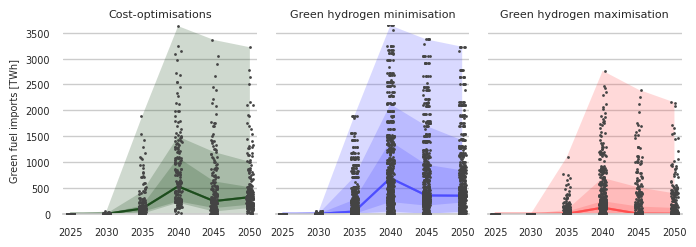

In [45]:
# IMPORTS

fig, axs = plt.subplots(
    1, 3, figsize=(page_width, 6 * cm), sharey=True, layout="constrained"
)

palette = {"opt": "#114411", "min": "#4444ff55", "max": "#ff444455"}

# Sense pretty names
sense_pretty = {
    "opt": "Cost-optimisations",
    "min": "Green hydrogen minimisation",
    "max": "Green hydrogen maximisation",
}

for i, sense in enumerate(["opt", "min", "max"]):
    ax = axs[i]

    # First a scatter-plot of dac
    sns.stripplot(
        data=df.xs(sense, level="sense"),
        x="horizon",
        y="imports",
        orient="v",
        native_scale=True,
        color="#444444",
        ax=ax,
        s=2,
    )

    for quantile, alpha in zip([100, 75, 50], [0.3, 0.5, 0.7]):
        sns.lineplot(
            data=df.xs(sense, level="sense"),
            x="horizon",
            y="imports",
            color=palette[sense],
            estimator=np.median,
            errorbar=("pi", quantile),
            err_kws={"edgecolor": "none"},
            alpha=alpha,
            ax=ax,
        )

    ax.set_ylim(bottom=0, top=df.imports.max())
    ax.set_xlim(2024, 2051)

    # Turn off x-grid
    ax.xaxis.grid(False)

    # Turn off spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

    # Set labels
    ax.set_ylabel("Green fuel imports [TWh]", fontsize=labelsize)
    ax.set_xlabel(None)

    # Tick font
    ax.tick_params(axis="both", which="major", labelsize=labelsize)

    ax.set_title(sense_pretty[sense], fontsize=textsize)

plt.savefig("figures/imports.pdf", dpi=300, transparent=True)

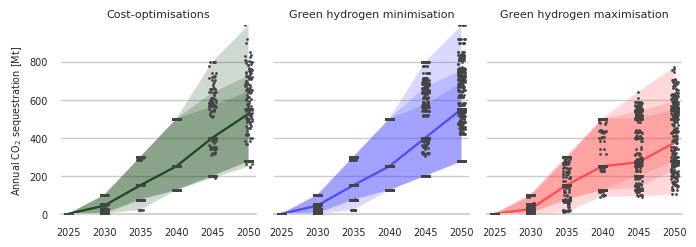

In [46]:
# Sequestration

fig, axs = plt.subplots(
    1, 3, figsize=(page_width, 6 * cm), sharey=True, layout="constrained"
)

palette = {"opt": "#114411", "min": "#4444ff55", "max": "#ff444455"}

# Sense pretty names
sense_pretty = {
    "opt": "Cost-optimisations",
    "min": "Green hydrogen minimisation",
    "max": "Green hydrogen maximisation",
}

for i, sense in enumerate(["opt", "min", "max"]):
    ax = axs[i]

    # First a scatter-plot of dac
    sns.stripplot(
        data=df.xs(sense, level="sense") / 1e6,
        x="horizon",
        y="co2seq",
        orient="v",
        native_scale=True,
        color="#444444",
        ax=ax,
        s=2,
    )

    for quantile, alpha in zip([100, 75, 50], [0.3, 0.5, 0.7]):
        sns.lineplot(
            data=df.xs(sense, level="sense") / 1e6,
            x="horizon",
            y="co2seq",
            color=palette[sense],
            estimator=np.median,
            errorbar=("pi", quantile),
            err_kws={"edgecolor": "none"},
            alpha=alpha,
            ax=ax,
        )

    ax.set_ylim(bottom=0, top=df.co2seq.max() / 1e6)
    ax.set_xlim(2024, 2051)

    # Turn off x-grid
    ax.xaxis.grid(False)

    # Turn off spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

    # Set labels
    ax.set_ylabel("Annual CO$_2$ sequestration [Mt]", fontsize=labelsize)
    ax.set_xlabel(None)

    # Tick font
    ax.tick_params(axis="both", which="major", labelsize=labelsize)

    ax.set_title(sense_pretty[sense], fontsize=textsize)

plt.savefig("figures/sequestration.pdf", dpi=300, transparent=True)

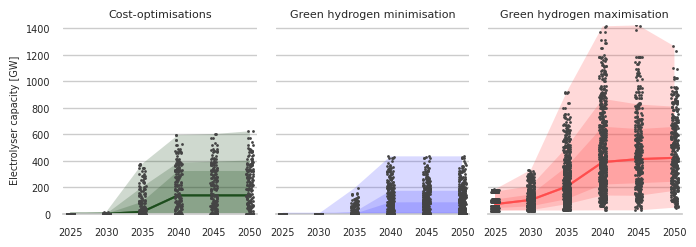

In [47]:
# Electrolyser capacity

fig, axs = plt.subplots(
    1, 3, figsize=(page_width, 6 * cm), sharey=True, layout="constrained"
)

palette = {"opt": "#114411", "min": "#4444ff55", "max": "#ff444455"}

# Sense pretty names
sense_pretty = {
    "opt": "Cost-optimisations",
    "min": "Green hydrogen minimisation",
    "max": "Green hydrogen maximisation",
}

for i, sense in enumerate(["opt", "min", "max"]):
    ax = axs[i]

    sns.stripplot(
        data=df.xs(sense, level="sense") / 1e3,
        x="horizon",
        y="elec_cap",
        orient="v",
        native_scale=True,
        color="#444444",
        ax=ax,
        s=2,
    )

    for quantile, alpha in zip([100, 75, 50], [0.3, 0.5, 0.7]):
        sns.lineplot(
            data=df.xs(sense, level="sense") / 1e3,
            x="horizon",
            y="elec_cap",
            color=palette[sense],
            estimator=np.median,
            errorbar=("pi", quantile),
            err_kws={"edgecolor": "none"},
            alpha=alpha,
            ax=ax,
        )

    ax.set_ylim(bottom=0, top=df.elec_cap.max() / 1e3)
    ax.set_xlim(2024, 2051)

    # Turn off x-grid
    ax.xaxis.grid(False)

    # Turn off spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

    # Set labels
    ax.set_ylabel("Electrolyser capacity [GW]", fontsize=labelsize)
    ax.set_xlabel(None)

    # Tick font
    ax.tick_params(axis="both", which="major", labelsize=labelsize)

    ax.set_title(sense_pretty[sense], fontsize=textsize)

plt.savefig("figures/elec_cap.pdf", dpi=300, transparent=True)

In [48]:
# Display median cost-optimal pathway
display((df.xs("opt", level="sense").groupby(["horizon"]).median()["elec_cap"] / 1e3).round(0))

horizon
2025      0.0
2030      0.0
2035     15.0
2040    139.0
2045    139.0
2050    139.0
Name: elec_cap, dtype: float64

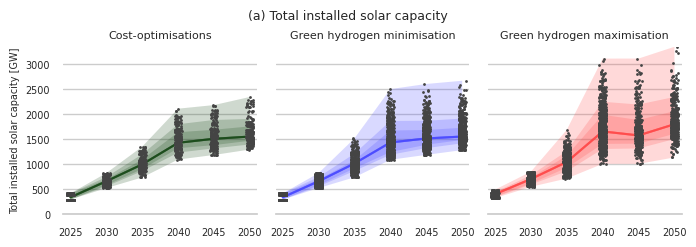

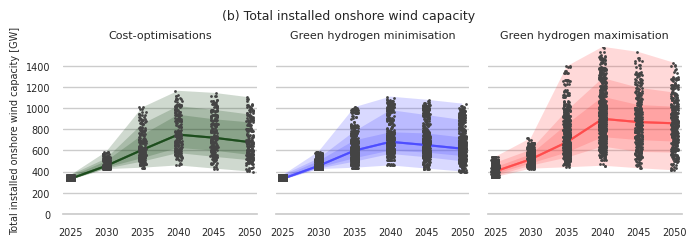

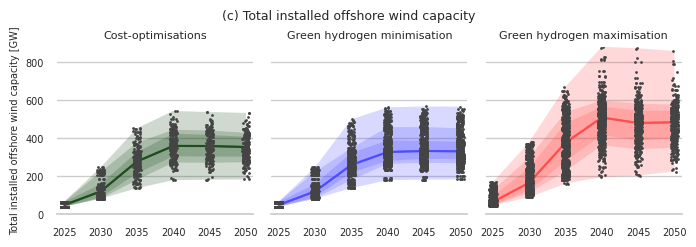

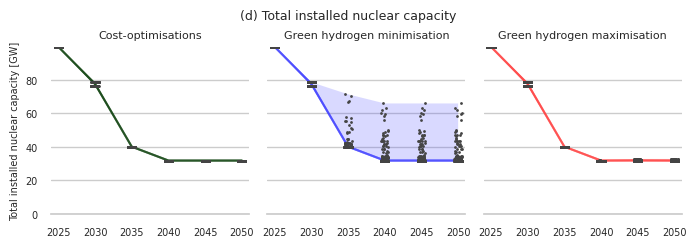

In [49]:
# Renewables + nuclear

pretty_names = {
    "solar": "solar",
    "onwind": "onshore wind",
    "offwind": "offshore wind",
    "nuclear": "nuclear",
}

for j, carrier in enumerate(["solar", "onwind", "offwind", "nuclear"]):

    fig, axs = plt.subplots(
        1, 3, figsize=(page_width, 6 * cm), sharey=True, layout="constrained"
    )

    palette = {"opt": "#114411", "min": "#4444ff55", "max": "#ff444455"}

    # Sense pretty names
    sense_pretty = {
        "opt": "Cost-optimisations",
        "min": "Green hydrogen minimisation",
        "max": "Green hydrogen maximisation",
    }

    for i, sense in enumerate(["opt", "min", "max"]):
        ax = axs[i]

        # First a scatter-plot of dac
        sns.stripplot(
            data=df.xs(sense, level="sense") / 1e3,
            x="horizon",
            y=f"total_{carrier}",
            orient="v",
            native_scale=True,
            color="#444444",
            ax=ax,
            s=2,
        )

        for quantile, alpha in zip([100, 75, 50], [0.3, 0.5, 0.7]):
            sns.lineplot(
                data=df.xs(sense, level="sense") / 1e3,
                x="horizon",
                y=f"total_{carrier}",
                color=palette[sense],
                estimator=np.median,
                errorbar=("pi", quantile),
                err_kws={"edgecolor": "none"},
                alpha=alpha,
                ax=ax,
            )

        ax.set_ylim(bottom=0, top=df[f"total_{carrier}"].max() / 1e3)
        ax.set_xlim(2024, 2051)

        # Turn off x-grid
        ax.xaxis.grid(False)

        # Turn off spines
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)

        # Set labels
        ax.set_ylabel(
            f"Total installed {pretty_names[carrier]} capacity [GW]", fontsize=labelsize
        )
        ax.set_xlabel(None)

        # Tick font
        ax.tick_params(axis="both", which="major", labelsize=labelsize)

        # X ticks every 5 years
        ax.xaxis.set_major_locator(plt.MultipleLocator(5))

        ax.set_title(sense_pretty[sense], fontsize=textsize)

    # Title figure
    fig.suptitle(
        f"{['(a)', '(b)', '(c)', '(d)'][j]} Total installed {pretty_names[carrier]} capacity",
        fontsize=titlesize,
    )

    plt.savefig(f"figures/{carrier}.pdf", dpi=300, transparent=True)

In [50]:
# Display median pathways of above carriers
carriers = ["solar", "onwind", "offwind", "nuclear"]
for carrier in carriers:
    display(
        (
            df.xs("opt", level="sense").groupby("horizon").median()[f"total_{carrier}"]
            / 1e3
        ).round(-1)
    )

horizon
2025     330.0
2030     650.0
2035     990.0
2040    1430.0
2045    1510.0
2050    1550.0
Name: total_solar, dtype: float64

horizon
2025    330.0
2030    450.0
2035    610.0
2040    750.0
2045    720.0
2050    680.0
Name: total_onwind, dtype: float64

horizon
2025     50.0
2030    120.0
2035    280.0
2040    360.0
2045    360.0
2050    350.0
Name: total_offwind, dtype: float64

horizon
2025    100.0
2030     80.0
2035     40.0
2040     30.0
2045     30.0
2050     30.0
Name: total_nuclear, dtype: float64

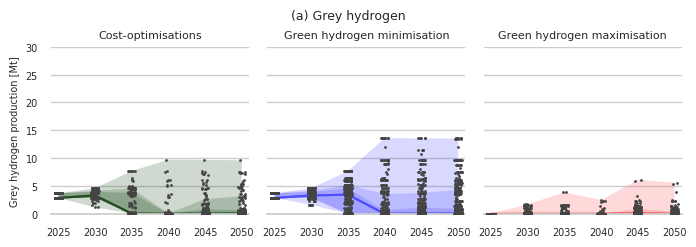

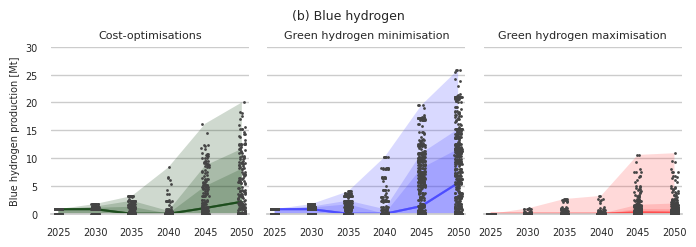

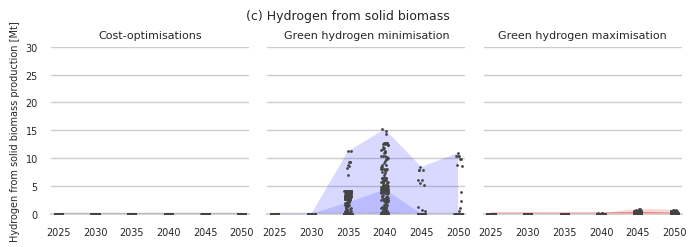

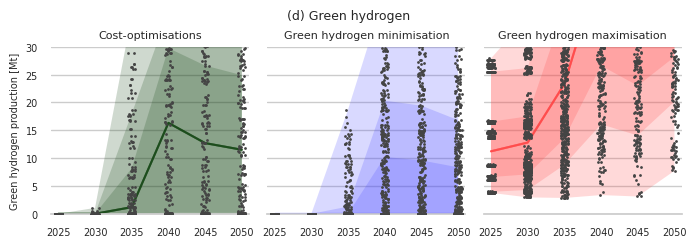

In [51]:
# Grey + blue hydrogen

pretty_names = {
    "smr": "Grey hydrogen",
    "smr_cc": "Blue hydrogen",
    "bio_hydrogen": "Hydrogen from solid biomass",
    "h2prod": "Green hydrogen",
    # "ammonia_cracking": "Ammonia cracking",
}

h2_prod_max_y = 30

for j, carrier in enumerate(pretty_names.keys()):  # , "ammonia_cracking"]):

    fig, axs = plt.subplots(
        1, 3, figsize=(page_width, 6 * cm), sharey=True, layout="constrained"
    )

    palette = {"opt": "#114411", "min": "#4444ff55", "max": "#ff444455"}

    # Sense pretty names
    sense_pretty = {
        "opt": "Cost-optimisations",
        "min": "Green hydrogen minimisation",
        "max": "Green hydrogen maximisation",
    }

    for i, sense in enumerate(["opt", "min", "max"]):
        ax = axs[i]

        # First a scatter-plot of dac
        sns.stripplot(
            data=df.xs(sense, level="sense"),
            x="horizon",
            y=carrier,
            orient="v",
            native_scale=True,
            color="#444444",
            ax=ax,
            s=2,
        )

        for quantile, alpha in zip([100, 75, 50], [0.3, 0.5, 0.7]):
            sns.lineplot(
                data=df.xs(sense, level="sense"),
                x="horizon",
                y=carrier,
                color=palette[sense],
                estimator=np.median,
                errorbar=("pi", quantile),
                err_kws={"edgecolor": "none"},
                alpha=alpha,
                ax=ax,
            )

        ax.set_ylim(bottom=0, top=h2_prod_max_y)
        ax.set_xlim(2024, 2051)

        # Turn off x-grid
        ax.xaxis.grid(False)

        # Turn off spines
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)

        # Set labels
        ax.set_ylabel(f"{pretty_names[carrier]} production [Mt]", fontsize=labelsize)
        ax.set_xlabel(None)

        # Tick font
        ax.tick_params(axis="both", which="major", labelsize=labelsize)

        # X ticks every 5 years
        ax.xaxis.set_major_locator(plt.MultipleLocator(5))

        ax.set_title(sense_pretty[sense], fontsize=textsize)

    # Title figure
    fig.suptitle(
        f"{['(a)', '(b)', '(c)', '(d)'][j]} {pretty_names[carrier]}",
        fontsize=titlesize,
    )

    plt.savefig(
        f"figures/h2prod_by_{carrier.replace('h2prod', 'green')}.pdf",
        dpi=300,
        transparent=True,
    )

In [ ]:
# Calculate what fraction of hydrogen production is green on average
frac_green = df.h2prod / (df.h2prod + df.smr + df.smr_cc + df.bio_hydrogen)

frac_green = frac_green.reset_index().rename(columns={0: "fraction"})

frac_green.groupby(["horizon", "sense"]).fraction.mean().unstack().round(3)

sense,max,min,opt
horizon,,,
2025,1.000,0.000,0.000
2030,0.981,0.000,0.007
2035,0.977,0.103,0.524
2040,0.993,0.324,0.797
2045,0.947,0.304,0.652
2050,0.960,0.268,0.609


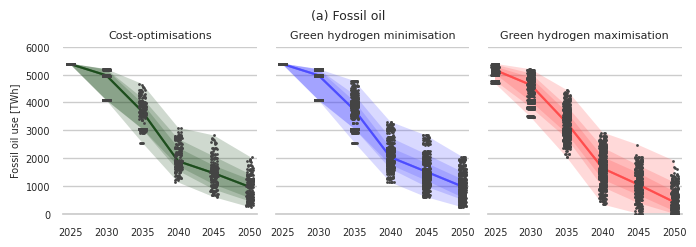

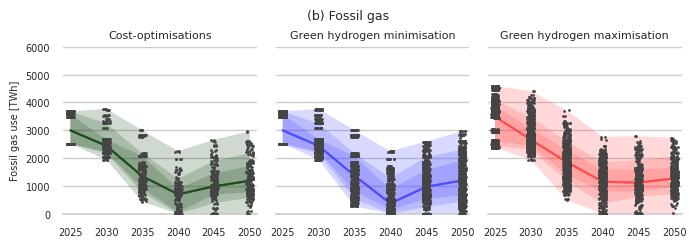

In [53]:
# Fossil oil and gas

pretty_names = {
    "fossil_oil": "Fossil oil",
    "fossil_gas": "Fossil gas",
}

for j, carrier in enumerate(pretty_names.keys()):

    fig, axs = plt.subplots(
        1, 3, figsize=(page_width, 6 * cm), sharey=True, layout="constrained"
    )

    palette = {"opt": "#114411", "min": "#4444ff55", "max": "#ff444455"}

    # Sense pretty names
    sense_pretty = {
        "opt": "Cost-optimisations",
        "min": "Green hydrogen minimisation",
        "max": "Green hydrogen maximisation",
    }

    for i, sense in enumerate(["opt", "min", "max"]):
        ax = axs[i]

        # First a scatter-plot of dac
        sns.stripplot(
            data=df.xs(sense, level="sense") / 1e6,
            x="horizon",
            y=carrier,
            orient="v",
            native_scale=True,
            color="#444444",
            ax=ax,
            s=2,
        )

        for quantile, alpha in zip([100, 75, 50], [0.3, 0.5, 0.7]):
            sns.lineplot(
                data=df.xs(sense, level="sense") / 1e6,
                x="horizon",
                y=carrier,
                color=palette[sense],
                estimator=np.median,
                errorbar=("pi", quantile),
                err_kws={"edgecolor": "none"},
                alpha=alpha,
                ax=ax,
            )

        ax.set_ylim(bottom=0, top=6000)
        ax.set_xlim(2024, 2051)

        # Turn off x-grid
        ax.xaxis.grid(False)

        # Turn off spines
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)

        # Set labels
        ax.set_ylabel(f"{pretty_names[carrier]} use [TWh]", fontsize=labelsize)
        ax.set_xlabel(None)

        # Tick font
        ax.tick_params(axis="both", which="major", labelsize=labelsize)

        # X ticks every 5 years
        ax.xaxis.set_major_locator(plt.MultipleLocator(5))

        ax.set_title(sense_pretty[sense], fontsize=textsize)

    # Title figure
    fig.suptitle(
        f"{['(a)', '(b)', '(c)', '(d)'][j]} {pretty_names[carrier]}",
        fontsize=titlesize,
    )

    plt.savefig(
        f"figures/{carrier}.pdf",
        dpi=300,
        transparent=True,
    )

In [54]:
# Interquantile range of oil and gas production
for carrier in ["fossil_oil", "fossil_gas"]:
    print(f"Range in cost-optimisations, use of {carrier} in TWh:")
    display(
        (
            df.xs("opt", level="sense")
            .groupby(["horizon"])[carrier]
            .quantile([0.25, 0.75])
            .unstack()
            / 1e6
        ).round(-1)
    )

    print("Difference between opt and max:")
    display(
        (
            (
                df.xs("max", level="sense")
                .droplevel("scenario")
                .xs(0.05, level="slack")
                - df.xs("opt", level="sense").droplevel("scenario")
            )
            .groupby(["horizon"])[carrier]
            .mean()
            / 1e6
        ).round(-1)
    )

Range in cost-optimisations, use of fossil_oil in TWh:


,0.25,0.75
horizon,,
2025,5360.0,5390.0
2030,4090.0,5180.0
2035,3050.0,3980.0
2040,1710.0,2380.0
2045,1050.0,1730.0
2050,560.0,1230.0


Difference between opt and max:


horizon
2025   -220.0
2030   -230.0
2035   -290.0
2040   -360.0
2045   -250.0
2050   -300.0
Name: fossil_oil, dtype: float64

Range in cost-optimisations, use of fossil_gas in TWh:


,0.25,0.75
horizon,,
2025,2520.0,3570.0
2030,2230.0,2670.0
2035,940.0,2070.0
2040,50.0,900.0
2045,700.0,1450.0
2050,770.0,1720.0


Difference between opt and max:


horizon
2025    230.0
2030    210.0
2035    350.0
2040    450.0
2045     60.0
2050     10.0
Name: fossil_gas, dtype: float64

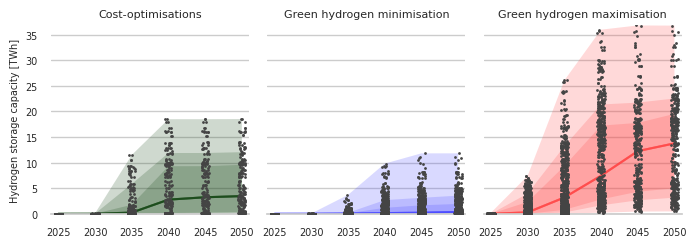

In [55]:
# H2 storage capacity

fig, axs = plt.subplots(
    1, 3, figsize=(page_width, 6 * cm), sharey=True, layout="constrained"
)

palette = {"opt": "#114411", "min": "#4444ff55", "max": "#ff444455"}

# Sense pretty names
sense_pretty = {
    "opt": "Cost-optimisations",
    "min": "Green hydrogen minimisation",
    "max": "Green hydrogen maximisation",
}

for i, sense in enumerate(["opt", "min", "max"]):
    ax = axs[i]

    sns.stripplot(
        data=df.xs(sense, level="sense") / 1e6,
        x="horizon",
        y="total_h2_storage",
        orient="v",
        native_scale=True,
        color="#444444",
        ax=ax,
        s=2,
    )

    for quantile, alpha in zip([100, 75, 50], [0.3, 0.5, 0.7]):
        sns.lineplot(
            data=df.xs(sense, level="sense") / 1e6,
            x="horizon",
            y="total_h2_storage",
            color=palette[sense],
            estimator=np.median,
            errorbar=("pi", quantile),
            err_kws={"edgecolor": "none"},
            alpha=alpha,
            ax=ax,
        )

    ax.set_ylim(bottom=0, top=df.total_h2_storage.max() / 1e6)
    ax.set_xlim(2024, 2051)

    # Turn off x-grid
    ax.xaxis.grid(False)

    # Turn off spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

    # Set labels
    ax.set_ylabel("Hydrogen storage capacity [TWh]", fontsize=labelsize)
    ax.set_xlabel(None)

    # Tick font
    ax.tick_params(axis="both", which="major", labelsize=labelsize)

    ax.set_title(sense_pretty[sense], fontsize=textsize)

plt.savefig("figures/h2_storage.pdf", dpi=300, transparent=True)

# Completeness of results

In [56]:
num_nan = df.h2prod.groupby(["horizon", "sense"]).apply(
    lambda x: x.isna().sum()
).unstack("horizon").astype(int)
num_tot = df.h2prod.groupby(["horizon", "sense"]).apply(
    lambda x: len(x)
).unstack("horizon").astype(int)


display(num_nan)

display((num_nan / num_tot).round(2) * 100)

horizon,2025,2030,2035,2040,2045,2050
sense,,,,,,
max,0,0,0,1,250,271
min,0,0,0,0,1,1
opt,0,0,0,0,0,0


horizon,2025,2030,2035,2040,2045,2050
sense,,,,,,
max,0.0,0.0,0.0,0.0,39.0,42.0
min,0.0,0.0,0.0,0.0,0.0,0.0
opt,0.0,0.0,0.0,0.0,0.0,0.0
